# Architecture Exploration

This is a notebook dedicated specifically to intensively testing different MLP architectures to choose the one that will be subjected to Grid Search Cross-Validation in the Project Notebook. All the preprocessing steps of the Project Notebook have been carried out prior to the models' design and training (without commentary, for the sake of brevity).

9 different architectures will be tested, each with 3+ different combinations of hyperparameters. For the sake of computational simplicity, they will be trained on only 50 epochs (the networks converge on a best validation loss pretty early during training, as it will be seen). It will be attempted for the networks to first overfit, and then tweak them from there.

In [1]:
# import data
import pandas as pd

df = pd.read_csv('bank-full.csv', sep=';')

In [2]:
# drop 'duration' column from dataset
df = df.drop('duration', axis=1)

In [3]:
# define numerical and categorical labels
numerical = ['age', 'balance', 'campaign', 'pdays', 'previous']
categorical = ['job', 'day', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

In [4]:
# define mapping function
def day2week_mapper(day):
    if 1 <= day and day <= 7:
        return 1
    elif 8 <= day and day <= 14:
        return 2
    elif 15 <= day and day <= 21:
        return 3
    elif 22 <= day and day <= 31:
        return 4
    else: return 0 #unnecessary but it closes the if-statement

# apply mapping   
df['day'] = df['day'].apply(day2week_mapper)

In [5]:
# apply func
df[categorical] = df[categorical].apply(lambda x: x.astype('category'))

In [6]:
# subtract 1 to all the values in the 'campaign' column
df['campaign'] = df['campaign'] - 1

In [7]:
# method to count outliers in a series 
def get_outliers(feature, k):
    feature_outliers = pd.DataFrame()
    Q3 = df[feature].quantile(0.75)
    Q1 = df[feature].quantile(0.25)
    iqr = Q3 - Q1
    for i in range(df.index.size):
        client = df.loc[i]
        if client[feature] < Q1 - k * iqr or client[feature] > Q3 + k * iqr:
            feature_outliers = feature_outliers.append(client)
    return feature_outliers

In [8]:
# Select all outliers in the dataframe and drop duplicate rows. 
outliers = pd.DataFrame()

for feature in numerical:
    outliers = outliers.append(get_outliers(feature, 1.5))
    
outliers = outliers.drop_duplicates()

# Number of unique outliers in the data
print(outliers.shape[0], 'outliers in the data')

14804 outliers in the data


In [9]:
# Calculate and report new value counts of target variable after having dropped outliers
val_counts_dropped = {'yes': df.y.value_counts()[1] - outliers.y.value_counts()[1], 
                      'no': df.y.value_counts()[0] - outliers.y.value_counts()[0]}

print(val_counts_dropped)
print('New ratio of "yes" to "no" is:', '1:{:.1f}'.format(val_counts_dropped['no'] / val_counts_dropped['yes']))

{'yes': 2684, 'no': 27723}
New ratio of "yes" to "no" is: 1:10.3


In [10]:
# Separate outliers with 'yes' and 'no' target variables
outliers_y = outliers.loc[outliers.y == 'yes']
outliers_n = outliers.drop(outliers_y.index.values)
assert outliers_y.index.size == outliers.y.value_counts()[1] and outliers_n.index.size == outliers.y.value_counts()[0]

In [11]:
# Create a Data Frame with only the rows that contain the target variable 'yes' and check for equality
df_y = df.loc[df.y == 'yes']
assert df_y.index.size == df.y.value_counts()[1]

# Adaptation of method to count outliers in a series (this time using df_y instead of df)
def get_outliers_y(feature, k):
    feature_outliers = pd.DataFrame()
    Q3 = df_y[feature].quantile(0.75)
    Q1 = df_y[feature].quantile(0.25)
    iqr = Q3 - Q1
    for i in df_y.index.values:
        client = df_y.loc[i]
        if client[feature] < Q1 - k * iqr or client[feature] > Q3 + k * iqr:
            feature_outliers = feature_outliers.append(client)
    return feature_outliers

In [12]:
# Select all 'outliers' in df_y and drop duplicate rows. 
outliers_y = pd.DataFrame()

for feature in numerical:
    outliers_y = outliers_y.append(get_outliers_y(feature, 2))
    
outliers_y = outliers_y.drop_duplicates()

# Number of unique outliers in the data
print(outliers_y.shape[0], '"yes" outliers in the data')

1235 "yes" outliers in the data


In [13]:
# drop 'no' outliers
df = df.drop(outliers_n.index.values)

# drop 'yes' outliers
df = df.drop(outliers_y.index.values)

In [14]:
# Reset Data Frame index for better presentation from now onwards
df.reset_index(drop=True, inplace=True)

In [15]:
# Replace -1 with new value in df.pdays
df.pdays = df.pdays.replace(to_replace=-1, value=1.5*df.pdays.max())

In [16]:
# Load the features onto a dummy data frame
import numpy as np
df_test = df[numerical]

In [17]:
# Initiate a dictionary and possible values of lambda
std = {}
lmbda = [-2.0, -0.5, 0.0, 0.5, 1.0, 2.0]

# Iterate over numerical features and each value of lambda for each feature
for feature in numerical:
    feature_std = {}
    for i in lmbda:
        dummy = df_test[feature]
        if i == 0.0:
            feature_std[str(i)] = dummy.apply(lambda x: np.log(x + 0.01)).std()
        else:
            feature_std[str(i)] = dummy.apply(lambda x: (x + 0.01) ** i).std()
    std[str(feature)] = feature_std

# Select best value of lambda for each feature
best_lmbda = dict((feature, min(std[feature], key=(lambda k: std[feature][k]))) for feature in numerical)
print(best_lmbda)

{'age': '-2.0', 'balance': '-0.5', 'campaign': '0.5', 'pdays': '-2.0', 'previous': '0.5'}


In [18]:
# Transform skewed features with best value of lambda:
for feature in numerical:
    df[feature] = df[feature].apply(lambda x: (x + 0.01) ** float(best_lmbda[feature])) 

In [19]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
df[numerical] = scaler.fit_transform(df[numerical])

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [20]:
# Replace values in target variable
target = df.y.replace(to_replace=['yes', 'no'], value=[1, 0])

# Drop target variable from data set before one-hot encoding
features = df.drop('y', axis=1)

# One-hot encode features
features = pd.get_dummies(features)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

53 total features after one-hot encoding.


In [21]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 25421 samples.
Testing set has 6356 samples.


In [22]:
# Import PCA
from sklearn.decomposition import PCA

# Create PCA object that seeks to retain 95% of the variance and fit it to the training data
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train)

# Transform X_train and X_test data using PCA
X_train_red = pca.transform(X_train)
X_test_red = pca.transform(X_test)

In [23]:
# PCA overview
print('Variance captured by PCA: {:.1f}%'.format(pca.n_components*100))
print('Principal Components shape:', pca.components_.shape)

# Compare training set dimensions before and after PCA
print('Training set dimensions: \nBefore PCA:', X_train.shape, '\nAfter PCA:', X_train_red.shape)

Variance captured by PCA: 95.0%
Principal Components shape: (27, 53)
Training set dimensions: 
Before PCA: (25421, 53) 
After PCA: (25421, 27)


In [24]:
### FULL CREDIT TO ARSENY KRAVCHENKO FOR THE CODE BELOW

import numpy as np
from sklearn.metrics import fbeta_score
from keras import backend as K


def f_2(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [39]:
# Import and set random seeds for reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

## Preambular Imports & Methods

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.initializers import RandomUniform

In [56]:
import matplotlib.pyplot as plt
% matplotlib inline

# Plotting method to facilitate visualization
def plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylim((0.2, 0.4))
    plt.show()

from collections import defaultdict    
performances = defaultdict()

# Pipeline method to streamline testing
def testmodel(model, reduce_lr, batch, red_factor):

    # Create checkpointer and filepath
    filepath = 'arch_test_weights/' + str(model.name) + '.best.hdf5'
    checkpoint = ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)

    if reduce_lr:
        # Fit model to training data (WITH LR RED. CALLBACK)
        lr_red = ReduceLROnPlateau(factor=red_factor, patience=5, min_lr=0.00001)
        hist = model.fit(X_train_red, y_train, batch_size=batch, epochs=50,
                       validation_split=0.2, shuffle=True,
                       callbacks=[checkpoint, lr_red], verbose=2)
    else: 
        # Fit model to training data (WITHOUT LR RED. CALLBACK)
        hist = model.fit(X_train_red, y_train, batch_size=batch, epochs=50,
                       validation_split=0.2, shuffle=True,
                       callbacks=[checkpoint], verbose=2)

    # Plot performance
    plot(hist)

    # Load weights
    model.load_weights(filepath)

    # Report
    names = model.metrics_names
    scores = model.evaluate(X_test_red, y_test)
    score_dict = dict((name, score) for name, score in zip(names, scores))
    print(score_dict)
    
    # Add to dict 
    performances[model.name] = score_dict

## Model 1

Begin with simple architecture: 3 layers

In [52]:
def model_1(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu', kernel_initializer=RandomUniform(42)))
    model.add(Dense(nodes, activation=activation))
    model.add(Dense(nodes + 5, activation=activation))
    model.add(Dense(nodes + 10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

### Model 1.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.4270 - f_2: 0.1575 - acc: 0.8661 - val_loss: 0.3506 - val_f_2: 0.2130 - val_acc: 0.8895

Epoch 00001: val_loss improved from inf to 0.35059, saving model to arch_test_weights/model_1_1.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3447 - f_2: 0.2002 - acc: 0.8873 - val_loss: 0.3290 - val_f_2: 0.2029 - val_acc: 0.8903

Epoch 00002: val_loss improved from 0.35059 to 0.32902, saving model to arch_test_weights/model_1_1.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3334 - f_2: 0.2016 - acc: 0.8893 - val_loss: 0.3242 - val_f_2: 0.2266 - val_acc: 0.8928

Epoch 00003: val_loss improved from 0.32902 to 0.32419, saving model to arch_test_weights/model_1_1.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3272 - f_2: 0.2189 - acc: 0.8920 - val_loss: 0.3222 - val_f_2: 0.2475 - val_acc: 0.8948

Epoch 00004: val_loss improved from 0.32419 to 0.32217, saving model to arch_test_weights/model_1_1.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3217 - f_2: 0.2373 - acc


Epoch 00045: val_loss did not improve from 0.30480
Epoch 46/50
 - 1s - loss: 0.2959 - f_2: 0.2726 - acc: 0.9002 - val_loss: 0.3095 - val_f_2: 0.3287 - val_acc: 0.8987

Epoch 00046: val_loss did not improve from 0.30480
Epoch 47/50
 - 1s - loss: 0.2951 - f_2: 0.2660 - acc: 0.8995 - val_loss: 0.3165 - val_f_2: 0.2907 - val_acc: 0.9003

Epoch 00047: val_loss did not improve from 0.30480
Epoch 48/50
 - 1s - loss: 0.2952 - f_2: 0.2809 - acc: 0.9002 - val_loss: 0.3063 - val_f_2: 0.3120 - val_acc: 0.9001

Epoch 00048: val_loss did not improve from 0.30480
Epoch 49/50
 - 1s - loss: 0.2952 - f_2: 0.2820 - acc: 0.9010 - val_loss: 0.3066 - val_f_2: 0.3092 - val_acc: 0.9007

Epoch 00049: val_loss did not improve from 0.30480
Epoch 50/50
 - 1s - loss: 0.2942 - f_2: 0.2890 - acc: 0.9011 - val_loss: 0.3045 - val_f_2: 0.3082 - val_acc: 0.9005

Epoch 00050: val_loss improved from 0.30480 to 0.30448, saving model to arch_test_weights/model_1_1.best.hdf5


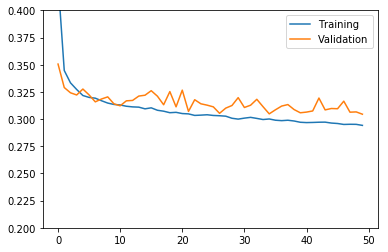

6356/6356 [==============================] - 0s 23us/step
{'loss': 0.3175301473233743, 'f_2': 0.26664522022204684, 'acc': 0.8975770924359916}


In [57]:
model_1_1 = model_1('model_1_1', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_1_1, False, 32, 0.5)

A bit of overfitting, as validation score rises after training continues to drop. Let's try to add a regularizer. 

### Model 1.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 1s - loss: 0.4534 - f_2: 0.1435 - acc: 0.8648 - val_loss: 0.3704 - val_f_2: 0.1543 - val_acc: 0.8846

Epoch 00001: val_loss improved from inf to 0.37037, saving model to arch_test_weights/model_1_2.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3467 - f_2: 0.1819 - acc: 0.8868 - val_loss: 0.3412 - val_f_2: 0.1897 - val_acc: 0.8887

Epoch 00002: val_loss improved from 0.37037 to 0.34123, saving model to arch_test_weights/model_1_2.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3342 - f_2: 0.2041 - acc: 0.8917 - val_loss: 0.3432 - val_f_2: 0.2254 - val_acc: 0.8934

Epoch 00003: val_loss did not improve from 0.34123
Epoch 4/50
 - 1s - loss: 0.3306 - f_2: 0.2168 - acc: 0.8932 - val_loss: 0.3290 - val_f_2: 0.2343 - val_acc: 0.8950

Epoch 00004: val_loss improved from 0.34123 to 0.32902, saving model to arch_test_weights/model_1_2.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3236 - f_2: 0.2221 - acc: 0.8946 - val_loss: 0.3220 - val_f_2: 0.2597 - val_acc: 0.


Epoch 00045: val_loss did not improve from 0.30558
Epoch 46/50
 - 1s - loss: 0.2896 - f_2: 0.3007 - acc: 0.9032 - val_loss: 0.3140 - val_f_2: 0.2814 - val_acc: 0.8968

Epoch 00046: val_loss did not improve from 0.30558
Epoch 47/50
 - 1s - loss: 0.2896 - f_2: 0.3052 - acc: 0.9031 - val_loss: 0.3130 - val_f_2: 0.2890 - val_acc: 0.8968

Epoch 00047: val_loss did not improve from 0.30558
Epoch 48/50
 - 1s - loss: 0.2898 - f_2: 0.3048 - acc: 0.9030 - val_loss: 0.3129 - val_f_2: 0.2849 - val_acc: 0.8970

Epoch 00048: val_loss did not improve from 0.30558
Epoch 49/50
 - 1s - loss: 0.2894 - f_2: 0.3035 - acc: 0.9034 - val_loss: 0.3135 - val_f_2: 0.2849 - val_acc: 0.8971

Epoch 00049: val_loss did not improve from 0.30558
Epoch 50/50
 - 1s - loss: 0.2894 - f_2: 0.3047 - acc: 0.9033 - val_loss: 0.3134 - val_f_2: 0.2849 - val_acc: 0.8970

Epoch 00050: val_loss did not improve from 0.30558


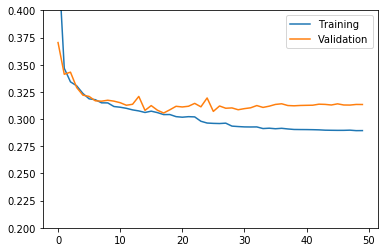

6356/6356 [==============================] - 0s 24us/step
{'loss': 0.3105286009061104, 'f_2': 0.2542086515165368, 'acc': 0.8967904341603465}


In [58]:
model_1_2 = model_1('model_1_2', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_1_2, True, 32, 0.5)

A bit more convergence by the training and validation losses. Slightly lower test loss, but slightly lower accuracy, too. Let's try to increase the number of nodes slightly.

### Model 1.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 1s - loss: 0.4260 - f_2: 0.1342 - acc: 0.8662 - val_loss: 0.3877 - val_f_2: 0.1420 - val_acc: 0.8830

Epoch 00001: val_loss improved from inf to 0.38771, saving model to arch_test_weights/model_1_3.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3470 - f_2: 0.2009 - acc: 0.8868 - val_loss: 0.3410 - val_f_2: 0.2259 - val_acc: 0.8909

Epoch 00002: val_loss improved from 0.38771 to 0.34103, saving model to arch_test_weights/model_1_3.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3358 - f_2: 0.2211 - acc: 0.8911 - val_loss: 0.3473 - val_f_2: 0.2342 - val_acc: 0.8938

Epoch 00003: val_loss did not improve from 0.34103
Epoch 4/50
 - 1s - loss: 0.3263 - f_2: 0.2512 - acc: 0.8940 - val_loss: 0.3499 - val_f_2: 0.2294 - val_acc: 0.8936

Epoch 00004: val_loss did not improve from 0.34103
Epoch 5/50
 - 1s - loss: 0.3230 - f_2: 0.2504 - acc: 0.8957 - val_loss: 0.3311 - val_f_2: 0.2704 - val_acc: 0.8979

Epoch 00005: val_loss improved from 0.34103 to 0.3311


Epoch 00046: val_loss did not improve from 0.30988
Epoch 47/50
 - 1s - loss: 0.2870 - f_2: 0.3031 - acc: 0.9040 - val_loss: 0.3148 - val_f_2: 0.2988 - val_acc: 0.8981

Epoch 00047: val_loss did not improve from 0.30988
Epoch 48/50
 - 1s - loss: 0.2866 - f_2: 0.3022 - acc: 0.9041 - val_loss: 0.3150 - val_f_2: 0.2990 - val_acc: 0.8985

Epoch 00048: val_loss did not improve from 0.30988
Epoch 49/50
 - 1s - loss: 0.2865 - f_2: 0.2970 - acc: 0.9040 - val_loss: 0.3154 - val_f_2: 0.2980 - val_acc: 0.8985

Epoch 00049: val_loss did not improve from 0.30988
Epoch 50/50
 - 1s - loss: 0.2867 - f_2: 0.3045 - acc: 0.9041 - val_loss: 0.3150 - val_f_2: 0.3027 - val_acc: 0.8985

Epoch 00050: val_loss did not improve from 0.30988


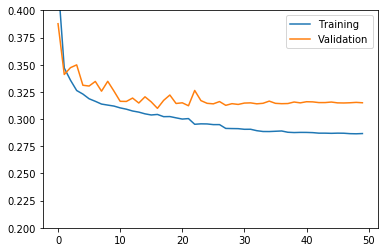

6356/6356 [==============================] - 0s 23us/step
{'loss': 0.30402954574498536, 'f_2': 0.27557973884473164, 'acc': 0.9004090622283139}


In [59]:
model_1_3 = model_1('model_1_3', nodes=20, activation='relu', optimizer='rmsprop')
testmodel(model_1_3, True, 32, 0.5)

A better test loss, F-2 Score, and testing accuracy than the past two models. Best one so far. 

## Model 2

Next: Try to increase the number of layers (+2), overfit, and reduce from there. 

In [60]:
# 2 new layers.
def model_2(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu', kernel_initializer=RandomUniform(42)))
    model.add(Dense(nodes, activation=activation))
    model.add(Dense(nodes + 2, activation=activation))
    model.add(Dense(nodes + 4, activation=activation)) 
    model.add(Dense(nodes + 6, activation=activation))
    model.add(Dense(nodes + 10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

### Model 2.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.4102 - f_2: 0.0221 - acc: 0.8702 - val_loss: 0.3968 - val_f_2: 0.0665 - val_acc: 0.8557

Epoch 00001: val_loss improved from inf to 0.39675, saving model to arch_test_weights/model_2_1.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3607 - f_2: 0.0547 - acc: 0.8751 - val_loss: 0.3526 - val_f_2: 0.1342 - val_acc: 0.8806

Epoch 00002: val_loss improved from 0.39675 to 0.35262, saving model to arch_test_weights/model_2_1.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3453 - f_2: 0.1247 - acc: 0.8824 - val_loss: 0.3553 - val_f_2: 0.0996 - val_acc: 0.8802

Epoch 00003: val_loss did not improve from 0.35262
Epoch 4/50
 - 1s - loss: 0.3387 - f_2: 0.1703 - acc: 0.8857 - val_loss: 0.3346 - val_f_2: 0.1640 - val_acc: 0.8852

Epoch 00004: val_loss improved from 0.35262 to 0.33462, saving model to arch_test_weights/model_2_1.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3341 - f_2: 0.1758 - acc: 0.8885 - val_loss: 0.3330 - val_f_2: 0.1440 - val_acc: 0.


Epoch 00046: val_loss did not improve from 0.31941
Epoch 47/50
 - 1s - loss: 0.3139 - f_2: 0.2493 - acc: 0.8970 - val_loss: 0.3659 - val_f_2: 0.2798 - val_acc: 0.8934

Epoch 00047: val_loss did not improve from 0.31941
Epoch 48/50
 - 1s - loss: 0.3131 - f_2: 0.2454 - acc: 0.8973 - val_loss: 0.3363 - val_f_2: 0.2884 - val_acc: 0.8948

Epoch 00048: val_loss did not improve from 0.31941
Epoch 49/50
 - 1s - loss: 0.3103 - f_2: 0.2671 - acc: 0.8982 - val_loss: 0.3609 - val_f_2: 0.2580 - val_acc: 0.8960

Epoch 00049: val_loss did not improve from 0.31941
Epoch 50/50
 - 1s - loss: 0.3150 - f_2: 0.2497 - acc: 0.8970 - val_loss: 0.3833 - val_f_2: 0.2958 - val_acc: 0.8946

Epoch 00050: val_loss did not improve from 0.31941


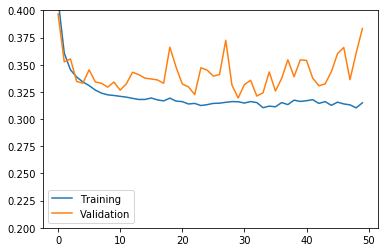

6356/6356 [==============================] - 0s 24us/step
{'loss': 0.32579790139213305, 'f_2': 0.2179624014547069, 'acc': 0.8956891125744435}


In [61]:
model_2_1 = model_2('model_2_1', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_2_1, False, 32, 0.5)

Very unstable validation loss, but overfitting is evident. Let's add a regularizer. 

### Model 2.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3973 - f_2: 0.0725 - acc: 0.8714 - val_loss: 0.3613 - val_f_2: 0.1597 - val_acc: 0.8789

Epoch 00001: val_loss improved from inf to 0.36133, saving model to arch_test_weights/model_2_2.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3427 - f_2: 0.1552 - acc: 0.8862 - val_loss: 0.3459 - val_f_2: 0.1629 - val_acc: 0.8877

Epoch 00002: val_loss improved from 0.36133 to 0.34585, saving model to arch_test_weights/model_2_2.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3286 - f_2: 0.2053 - acc: 0.8926 - val_loss: 0.3269 - val_f_2: 0.2039 - val_acc: 0.8918

Epoch 00003: val_loss improved from 0.34585 to 0.32689, saving model to arch_test_weights/model_2_2.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3238 - f_2: 0.2196 - acc: 0.8939 - val_loss: 0.3275 - val_f_2: 0.2289 - val_acc: 0.8932

Epoch 00004: val_loss did not improve from 0.32689
Epoch 5/50
 - 1s - loss: 0.3207 - f_2: 0.2347 - acc: 0.8958 - val_loss: 0.3289 - val_f_2: 0.2247 - val_acc: 0.

 - 1s - loss: 0.2886 - f_2: 0.2933 - acc: 0.9023 - val_loss: 0.3232 - val_f_2: 0.2778 - val_acc: 0.8979

Epoch 00047: val_loss did not improve from 0.31370
Epoch 48/50
 - 1s - loss: 0.2887 - f_2: 0.2834 - acc: 0.9023 - val_loss: 0.3228 - val_f_2: 0.2774 - val_acc: 0.8979

Epoch 00048: val_loss did not improve from 0.31370
Epoch 49/50
 - 1s - loss: 0.2885 - f_2: 0.2877 - acc: 0.9024 - val_loss: 0.3228 - val_f_2: 0.2774 - val_acc: 0.8979

Epoch 00049: val_loss did not improve from 0.31370
Epoch 50/50
 - 1s - loss: 0.2885 - f_2: 0.2924 - acc: 0.9024 - val_loss: 0.3226 - val_f_2: 0.2788 - val_acc: 0.8981

Epoch 00050: val_loss did not improve from 0.31370


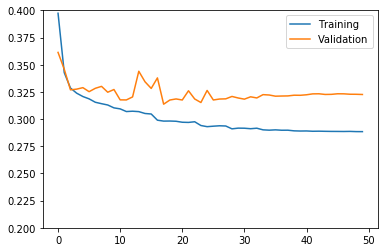

6356/6356 [==============================] - 0s 27us/step
{'loss': 0.3123961033650057, 'f_2': 0.26191543196638034, 'acc': 0.9000943989180559}


In [62]:
model_2_2 = model_2('model_2_2', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_2_2, True, 32, 0.5)

The high (and constant) validation loss could signify underfitting. Perhaps more nodes and a higher LR Reducer factor could aid this. 

### Model 2.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3998 - f_2: 0.0515 - acc: 0.8748 - val_loss: 0.3641 - val_f_2: 0.1140 - val_acc: 0.8810

Epoch 00001: val_loss improved from inf to 0.36412, saving model to arch_test_weights/model_2_3.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3475 - f_2: 0.1362 - acc: 0.8840 - val_loss: 0.3400 - val_f_2: 0.1859 - val_acc: 0.8893

Epoch 00002: val_loss improved from 0.36412 to 0.34004, saving model to arch_test_weights/model_2_3.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3361 - f_2: 0.1700 - acc: 0.8877 - val_loss: 0.3593 - val_f_2: 0.1496 - val_acc: 0.8867

Epoch 00003: val_loss did not improve from 0.34004
Epoch 4/50
 - 1s - loss: 0.3317 - f_2: 0.1732 - acc: 0.8896 - val_loss: 0.3383 - val_f_2: 0.1874 - val_acc: 0.8905

Epoch 00004: val_loss improved from 0.34004 to 0.33831, saving model to arch_test_weights/model_2_3.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3288 - f_2: 0.1923 - acc: 0.8904 - val_loss: 0.3390 - val_f_2: 0.1952 - val_acc: 0.

 - 1s - loss: 0.2959 - f_2: 0.3027 - acc: 0.9013 - val_loss: 0.3256 - val_f_2: 0.2846 - val_acc: 0.8979

Epoch 00045: val_loss did not improve from 0.31112
Epoch 46/50
 - 1s - loss: 0.2954 - f_2: 0.2859 - acc: 0.9011 - val_loss: 0.3200 - val_f_2: 0.2893 - val_acc: 0.8983

Epoch 00046: val_loss did not improve from 0.31112
Epoch 47/50
 - 1s - loss: 0.2956 - f_2: 0.3011 - acc: 0.9014 - val_loss: 0.3206 - val_f_2: 0.2939 - val_acc: 0.8989

Epoch 00047: val_loss did not improve from 0.31112
Epoch 48/50
 - 1s - loss: 0.2951 - f_2: 0.2895 - acc: 0.9015 - val_loss: 0.3277 - val_f_2: 0.2991 - val_acc: 0.8983

Epoch 00048: val_loss did not improve from 0.31112
Epoch 49/50
 - 1s - loss: 0.2936 - f_2: 0.2956 - acc: 0.9017 - val_loss: 0.3223 - val_f_2: 0.2983 - val_acc: 0.8977

Epoch 00049: val_loss did not improve from 0.31112
Epoch 50/50
 - 1s - loss: 0.2929 - f_2: 0.2925 - acc: 0.9021 - val_loss: 0.3276 - val_f_2: 0.2930 - val_acc: 0.8979

Epoch 00050: val_loss did not improve from 0.31112


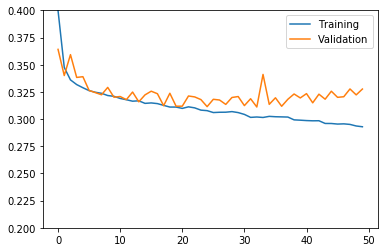

6356/6356 [==============================] - 0s 25us/step
{'loss': 0.3133692777404401, 'f_2': 0.2389909516119541, 'acc': 0.8966331025052175}


In [63]:
model_2_3 = model_2('model_2_3', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_2_3, True, 32, 0.7)

This last model does not show an improvement over model 1.3, which has shown the best performance so far in terms of all three scores. This could suggest that the model performs better with a lower number of hidden layers. 

## Model 3

Although it is evident from the experimentation above that the model performs better with a smaller number of layers, we still need to examine the possibility of the model performing with a higher number of nodes. 

Ideally, the number of nodes in the hidden layers should lie between the number of nodes at the output layer and the number of nodes at the input layer. However, for the sake of experimentation, we can try to increase the number of nodes well above this range.

In [68]:
def model_3(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu', kernel_initializer=RandomUniform(42)))
    model.add(Dense(nodes * 3, activation=activation))
    model.add(Dense(nodes * 6, activation=activation))
    model.add(Dense(nodes * 10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

### Model 3.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.4865 - f_2: 0.1551 - acc: 0.8744 - val_loss: 0.3529 - val_f_2: 0.1860 - val_acc: 0.8901

Epoch 00001: val_loss improved from inf to 0.35289, saving model to arch_test_weights/model_3_1.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3489 - f_2: 0.1951 - acc: 0.8885 - val_loss: 0.3467 - val_f_2: 0.2494 - val_acc: 0.8916

Epoch 00002: val_loss improved from 0.35289 to 0.34672, saving model to arch_test_weights/model_3_1.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3393 - f_2: 0.2045 - acc: 0.8914 - val_loss: 0.3350 - val_f_2: 0.2090 - val_acc: 0.8930

Epoch 00003: val_loss improved from 0.34672 to 0.33500, saving model to arch_test_weights/model_3_1.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3297 - f_2: 0.2123 - acc: 0.8926 - val_loss: 0.3266 - val_f_2: 0.2275 - val_acc: 0.8924

Epoch 00004: val_loss improved from 0.33500 to 0.32662, saving model to arch_test_weights/model_3_1.best.hdf5
Epoch 5/50
 - 2s - loss: 0.3255 - f_2: 0.2151 - acc


Epoch 00047: val_loss did not improve from 0.31896
Epoch 48/50
 - 2s - loss: 0.3178 - f_2: 0.3061 - acc: 0.9010 - val_loss: 0.4107 - val_f_2: 0.2633 - val_acc: 0.8970

Epoch 00048: val_loss did not improve from 0.31896
Epoch 49/50
 - 2s - loss: 0.3322 - f_2: 0.3137 - acc: 0.9009 - val_loss: 0.4052 - val_f_2: 0.2505 - val_acc: 0.8940

Epoch 00049: val_loss did not improve from 0.31896
Epoch 50/50
 - 2s - loss: 0.3175 - f_2: 0.3165 - acc: 0.9008 - val_loss: 0.4122 - val_f_2: 0.3615 - val_acc: 0.8975

Epoch 00050: val_loss did not improve from 0.31896


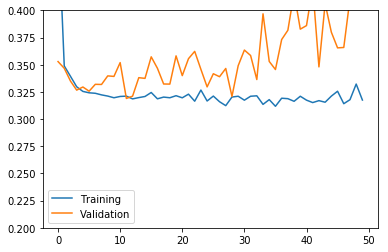

6356/6356 [==============================] - 0s 41us/step
{'loss': 0.32220875292247464, 'f_2': 0.22897857796155524, 'acc': 0.8969477658154756}


In [69]:
model_3_1 = model_3('model_3_1', nodes=50, activation='relu', optimizer='rmsprop')
testmodel(model_3_1, False, 32, 0.5)

Very strange performance on the part of the model. The best validation score was relatively low, compared to previous tests (0.31), but the performance of the model is not at all constant. Furthermore, the validation loss tends to increase. This is a common sign of overfitting. Let's try to increase the number of nodes, to attempt to overfit further, and then regulate. 

### Model 3.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 5s - loss: 0.5309 - f_2: 0.1481 - acc: 0.8757 - val_loss: 0.3497 - val_f_2: 0.2571 - val_acc: 0.8838

Epoch 00001: val_loss improved from inf to 0.34969, saving model to arch_test_weights/model_3_2.best.hdf5
Epoch 2/50
 - 4s - loss: 0.3437 - f_2: 0.2053 - acc: 0.8906 - val_loss: 0.3326 - val_f_2: 0.2262 - val_acc: 0.8932

Epoch 00002: val_loss improved from 0.34969 to 0.33255, saving model to arch_test_weights/model_3_2.best.hdf5
Epoch 3/50
 - 4s - loss: 0.3320 - f_2: 0.2045 - acc: 0.8914 - val_loss: 0.3271 - val_f_2: 0.1986 - val_acc: 0.8914

Epoch 00003: val_loss improved from 0.33255 to 0.32714, saving model to arch_test_weights/model_3_2.best.hdf5
Epoch 4/50
 - 4s - loss: 0.3292 - f_2: 0.2107 - acc: 0.8927 - val_loss: 0.3225 - val_f_2: 0.2343 - val_acc: 0.8952

Epoch 00004: val_loss improved from 0.32714 to 0.32252, saving model to arch_test_weights/model_3_2.best.hdf5
Epoch 5/50
 - 4s - loss: 0.3252 - f_2: 0.2138 - acc


Epoch 00047: val_loss did not improve from 0.31028
Epoch 48/50
 - 4s - loss: 0.3379 - f_2: 0.2709 - acc: 0.8944 - val_loss: 0.3660 - val_f_2: 0.2811 - val_acc: 0.8981

Epoch 00048: val_loss did not improve from 0.31028
Epoch 49/50
 - 4s - loss: 0.3440 - f_2: 0.2865 - acc: 0.8978 - val_loss: 0.3844 - val_f_2: 0.2739 - val_acc: 0.8966

Epoch 00049: val_loss did not improve from 0.31028
Epoch 50/50
 - 4s - loss: 0.3465 - f_2: 0.2831 - acc: 0.8938 - val_loss: 0.4281 - val_f_2: 0.2398 - val_acc: 0.8948

Epoch 00050: val_loss did not improve from 0.31028


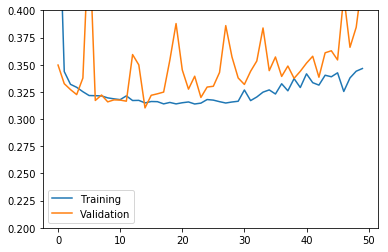

6356/6356 [==============================] - 0s 68us/step
{'loss': 0.31760977076388813, 'f_2': 0.21426896622708871, 'acc': 0.8958464442295725}


In [70]:
model_3_2 = model_3('model_3_2', nodes=100, activation='relu', optimizer='rmsprop')
testmodel(model_3_2, False, 32, 0.5)

Embarrasing performance. It would seem that increasing the number of nodes is not the way to go. Still, we need to rule out the possibility of using a high number of nodes along with a learning rate reducer. 

The performance of Model 3.1 (50 nodes) was the lesser of both evils, so we'll stick to that for the next test. 

### Model 3.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.4597 - f_2: 0.2162 - acc: 0.8802 - val_loss: 0.3698 - val_f_2: 0.2262 - val_acc: 0.8932

Epoch 00001: val_loss improved from inf to 0.36982, saving model to arch_test_weights/model_3_3.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3338 - f_2: 0.2431 - acc: 0.8961 - val_loss: 0.3658 - val_f_2: 0.3075 - val_acc: 0.8759

Epoch 00002: val_loss improved from 0.36982 to 0.36577, saving model to arch_test_weights/model_3_3.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3246 - f_2: 0.2575 - acc: 0.8972 - val_loss: 0.3386 - val_f_2: 0.2468 - val_acc: 0.8962

Epoch 00003: val_loss improved from 0.36577 to 0.33864, saving model to arch_test_weights/model_3_3.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3172 - f_2: 0.2564 - acc: 0.8983 - val_loss: 0.3200 - val_f_2: 0.2772 - val_acc: 0.8983

Epoch 00004: val_loss improved from 0.33864 to 0.32002, saving model to arch_test_weights/model_3_3.best.hdf5
Epoch 5/50
 - 2s - loss: 0.3122 - f_2: 0.2472 - acc


Epoch 00047: val_loss did not improve from 0.31040
Epoch 48/50
 - 2s - loss: 0.2641 - f_2: 0.3480 - acc: 0.9086 - val_loss: 0.3410 - val_f_2: 0.3234 - val_acc: 0.9001

Epoch 00048: val_loss did not improve from 0.31040
Epoch 49/50
 - 2s - loss: 0.2645 - f_2: 0.3422 - acc: 0.9084 - val_loss: 0.3369 - val_f_2: 0.3234 - val_acc: 0.9001

Epoch 00049: val_loss did not improve from 0.31040
Epoch 50/50
 - 2s - loss: 0.2640 - f_2: 0.3535 - acc: 0.9085 - val_loss: 0.3382 - val_f_2: 0.3234 - val_acc: 0.9001

Epoch 00050: val_loss did not improve from 0.31040


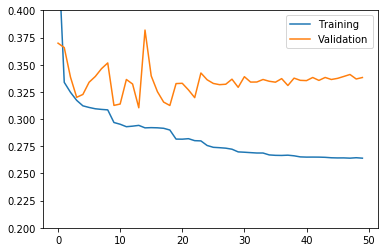

6356/6356 [==============================] - 0s 36us/step
{'loss': 0.3110759711025495, 'f_2': 0.28864923367902773, 'acc': 0.902139710434733}


In [71]:
model_3_3 = model_3('model_3_3', nodes=50, activation='relu', optimizer='rmsprop')
testmodel(model_3_3, True, 32, 0.5)

As it can be observed above, adding a learning rate reducer did not help. Therefore, we can conclude that an increase in the number of nodes does not necessarily provide a better model (which is the present case). 

From now forth, let's stick to the heuristic of having the number of nodes of the hidden layers be between the number of nodes of the input layer and the number of nodes of the output layer.

## Model 4

The Model 4 architecture will stick to the architecture of Model 1 (best performer, as of yet), but will add an activation function at the input layer, as well as a kernel initializer on all the layers, to observe performance.

In [77]:
def model_4(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation, kernel_initializer=RandomUniform(42)))
    model.add(Dense(nodes, activation=activation, kernel_initializer=RandomUniform(42)))
    model.add(Dense(nodes + 5, activation=activation, kernel_initializer=RandomUniform(42)))
    model.add(Dense(nodes + 10, activation=activation, kernel_initializer=RandomUniform(42)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

### Model 4.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 1.7391 - f_2: 0.0110 - acc: 0.8726 - val_loss: 1.8159 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 1.81593, saving model to arch_test_weights/model_4_1.best.hdf5
Epoch 2/50
 - 1s - loss: 1.7217 - f_2: 0.0079 - acc: 0.8726 - val_loss: 1.8033 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00002: val_loss improved from 1.81593 to 1.80331, saving model to arch_test_weights/model_4_1.best.hdf5
Epoch 3/50
 - 1s - loss: 1.7139 - f_2: 0.0110 - acc: 0.8726 - val_loss: 1.7981 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00003: val_loss improved from 1.80331 to 1.79810, saving model to arch_test_weights/model_4_1.best.hdf5
Epoch 4/50
 - 1s - loss: 1.7109 - f_2: 0.0149 - acc: 0.8726 - val_loss: 1.7961 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00004: val_loss improved from 1.79810 to 1.79612, saving model to arch_test_weights/model_4_1.best.hdf5
Epoch 5/50
 - 1s - loss: 1.7100 - f_2: 0.0110 - acc


Epoch 00044: val_loss did not improve from 1.79487
Epoch 45/50
 - 1s - loss: 1.7096 - f_2: 0.0094 - acc: 0.8726 - val_loss: 1.7949 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00045: val_loss did not improve from 1.79487
Epoch 46/50
 - 1s - loss: 1.7096 - f_2: 0.0110 - acc: 0.8726 - val_loss: 1.7949 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00046: val_loss did not improve from 1.79487
Epoch 47/50
 - 1s - loss: 1.7096 - f_2: 0.0142 - acc: 0.8726 - val_loss: 1.7949 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00047: val_loss did not improve from 1.79487
Epoch 48/50
 - 1s - loss: 1.7096 - f_2: 0.0126 - acc: 0.8726 - val_loss: 1.7949 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00048: val_loss did not improve from 1.79487
Epoch 49/50
 - 1s - loss: 1.7096 - f_2: 0.0063 - acc: 0.8726 - val_loss: 1.7949 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00049: val_loss did not improve from 1.79487
Epoch 50/50
 - 1s - loss: 1.7096 - f_2: 0.0142 - acc: 0.8726 - val_loss: 1.7949 - val_f_2: 0.0063 - val_acc:

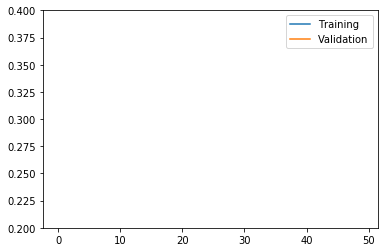

6356/6356 [==============================] - 0s 28us/step
{'loss': 1.6707572563404254, 'f_2': 0.0050346537366257995, 'acc': 0.8742920074768978}


In [78]:
model_4_1 = model_4('model_4_1', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_4_1, False, 32, 0.5)

Model 4.1 has been the worst one by far up until now. The initializer definitely did no good to the model's performance. The loss is higher than it has ever been, F-2 score and accuracy are at their lowest points. 

Before ruling out the initializer, we can experiment a bit further with it in place, just to ensure that we are not rushing the process. Let's attempt to include the initializer and activate the LR callback.

### Model 4.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 1.7425 - f_2: 0.0189 - acc: 0.8726 - val_loss: 1.8182 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 1.81818, saving model to arch_test_weights/model_4_2.best.hdf5
Epoch 2/50
 - 1s - loss: 1.7278 - f_2: 0.0205 - acc: 0.8726 - val_loss: 1.8086 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00002: val_loss improved from 1.81818 to 1.80858, saving model to arch_test_weights/model_4_2.best.hdf5
Epoch 3/50
 - 1s - loss: 1.7211 - f_2: 0.0126 - acc: 0.8726 - val_loss: 1.8046 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00003: val_loss improved from 1.80858 to 1.80463, saving model to arch_test_weights/model_4_2.best.hdf5
Epoch 4/50
 - 1s - loss: 1.7187 - f_2: 0.0079 - acc: 0.8726 - val_loss: 1.8033 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00004: val_loss improved from 1.80463 to 1.80329, saving model to arch_test_weights/model_4_2.best.hdf5
Epoch 5/50
 - 1s - loss: 1.7179 - f_2: 0.0173 - acc

 - 1s - loss: 1.7176 - f_2: 0.0142 - acc: 0.8726 - val_loss: 1.8025 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00044: val_loss did not improve from 1.80252
Epoch 45/50
 - 1s - loss: 1.7176 - f_2: 0.0142 - acc: 0.8726 - val_loss: 1.8025 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00045: val_loss did not improve from 1.80252
Epoch 46/50
 - 1s - loss: 1.7176 - f_2: 0.0173 - acc: 0.8726 - val_loss: 1.8025 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00046: val_loss did not improve from 1.80252
Epoch 47/50
 - 1s - loss: 1.7176 - f_2: 0.0126 - acc: 0.8726 - val_loss: 1.8025 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00047: val_loss did not improve from 1.80252
Epoch 48/50
 - 1s - loss: 1.7176 - f_2: 0.0063 - acc: 0.8726 - val_loss: 1.8025 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00048: val_loss did not improve from 1.80252
Epoch 49/50
 - 1s - loss: 1.7176 - f_2: 0.0142 - acc: 0.8726 - val_loss: 1.8025 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00049: val_loss did not improve from 1.80252
Epoc

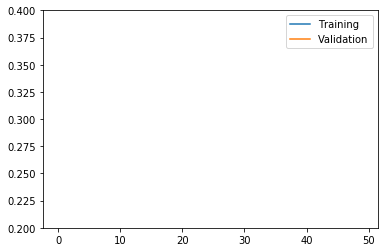

6356/6356 [==============================] - 0s 28us/step
{'loss': 1.6906892971620386, 'f_2': 0.0050346537366257995, 'acc': 0.8742920074768978}


In [79]:
model_4_2 = model_4('model_4_2', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_4_2, True, 32, 0.5)

Performance keeps worsening in the presence of the kernel initializer. To rule it out completely, I will make an exception to this exploratory process and design an architecture without it in any of the layers for Model 4.3, and observe that architecture's performance. This way, I can examine how the model performs with an activation function in the input layer. 

### Model 4.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3388 - f_2: 0.1078 - acc: 0.8817 - val_loss: 0.3050 - val_f_2: 0.2802 - val_acc: 0.9015

Epoch 00001: val_loss improved from inf to 0.30497, saving model to arch_test_weights/model_4_3.best.hdf5
Epoch 2/50
 - 1s - loss: 0.2913 - f_2: 0.2990 - acc: 0.9022 - val_loss: 0.2873 - val_f_2: 0.3016 - val_acc: 0.9017

Epoch 00002: val_loss improved from 0.30497 to 0.28730, saving model to arch_test_weights/model_4_3.best.hdf5
Epoch 3/50
 - 1s - loss: 0.2829 - f_2: 0.3185 - acc: 0.9033 - val_loss: 0.2852 - val_f_2: 0.3341 - val_acc: 0.9021

Epoch 00003: val_loss improved from 0.28730 to 0.28516, saving model to arch_test_weights/model_4_3.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2791 - f_2: 0.3367 - acc: 0.9048 - val_loss: 0.2816 - val_f_2: 0.3334 - val_acc: 0.9030

Epoch 00004: val_loss improved from 0.28516 to 0.28161, saving model to arch_test_weights/model_4_3.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2762 - f_2: 0.3420 - acc


Epoch 00047: val_loss did not improve from 0.27832
Epoch 48/50
 - 1s - loss: 0.2543 - f_2: 0.4389 - acc: 0.9127 - val_loss: 0.2902 - val_f_2: 0.3565 - val_acc: 0.9017

Epoch 00048: val_loss did not improve from 0.27832
Epoch 49/50
 - 1s - loss: 0.2534 - f_2: 0.4312 - acc: 0.9131 - val_loss: 0.2906 - val_f_2: 0.3505 - val_acc: 0.9027

Epoch 00049: val_loss did not improve from 0.27832
Epoch 50/50
 - 1s - loss: 0.2526 - f_2: 0.4371 - acc: 0.9139 - val_loss: 0.2928 - val_f_2: 0.3423 - val_acc: 0.9013

Epoch 00050: val_loss did not improve from 0.27832


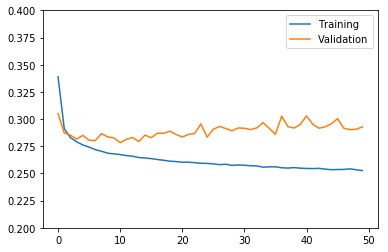

6356/6356 [==============================] - 0s 28us/step
{'loss': 0.28096253043679487, 'f_2': 0.3455249664800483, 'acc': 0.9027690372052922}


In [80]:
def model_4_3(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation))
    model.add(Dense(nodes + 5, activation=activation))
    model.add(Dense(nodes + 10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_4_3 = model_4_3('model_4_3', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_4_3, False, 32, 0.5)

Model 4.3 has obtained the best scores as of yet. It obtained the lowest loss and the highest F-2 Score that have been observed, along with the highest accuracy (higher than Model 1.3's 0.900...). 

As it can be seen in the graph above, the model reaches a minimun validation loss pretty quickly (before 10 epochs) and then the training and validation losses diverge from there. This is a sign of overfitting. Therefore, we can proceed our analysis by tweaking Model 4.3's architecture to reduce overfitting, while trying to keep minimizing underfitting.

## Model 5

Model 5's architecture will stick to the architecture proposed by Model 4.3, but will attempt to reduce overfitting by introducing L2 and L1 regularizers in the hidden layers of the network, both with a penalty of 0.001 (if this addition is found to be beneficial to the network's performance, the specific value of the penalty can be fine-tuned later during Grid Search Cross-Validation in the Project Notebook).

In [85]:
def model_5(name, nodes, activation, optimizer, regularizer, penalty):
    if regularizer == 1:
        reg = l1(penalty)
    else: reg = l2(penalty)
        
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=reg))
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=reg))
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=reg))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

### Model 5.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.4629 - f_2: 0.1057 - acc: 0.8717 - val_loss: 0.3674 - val_f_2: 0.2821 - val_acc: 0.9003

Epoch 00001: val_loss improved from inf to 0.36744, saving model to arch_test_weights/model_5_1.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3444 - f_2: 0.3000 - acc: 0.9030 - val_loss: 0.3337 - val_f_2: 0.3114 - val_acc: 0.9021

Epoch 00002: val_loss improved from 0.36744 to 0.33370, saving model to arch_test_weights/model_5_1.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3230 - f_2: 0.3186 - acc: 0.9030 - val_loss: 0.3214 - val_f_2: 0.3651 - val_acc: 0.9021

Epoch 00003: val_loss improved from 0.33370 to 0.32135, saving model to arch_test_weights/model_5_1.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3125 - f_2: 0.3363 - acc: 0.9045 - val_loss: 0.3131 - val_f_2: 0.3345 - val_acc: 0.9027

Epoch 00004: val_loss improved from 0.32135 to 0.31309, saving model to arch_test_weights/model_5_1.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3067 - f_2: 0.3303 - acc


Epoch 00042: val_loss improved from 0.29385 to 0.29367, saving model to arch_test_weights/model_5_1.best.hdf5
Epoch 43/50
 - 1s - loss: 0.2774 - f_2: 0.3900 - acc: 0.9072 - val_loss: 0.2986 - val_f_2: 0.4136 - val_acc: 0.9034

Epoch 00043: val_loss did not improve from 0.29367
Epoch 44/50
 - 1s - loss: 0.2770 - f_2: 0.3906 - acc: 0.9077 - val_loss: 0.2973 - val_f_2: 0.3427 - val_acc: 0.9025

Epoch 00044: val_loss did not improve from 0.29367
Epoch 45/50
 - 1s - loss: 0.2772 - f_2: 0.3943 - acc: 0.9079 - val_loss: 0.2936 - val_f_2: 0.3561 - val_acc: 0.9032

Epoch 00045: val_loss improved from 0.29367 to 0.29360, saving model to arch_test_weights/model_5_1.best.hdf5
Epoch 46/50
 - 1s - loss: 0.2769 - f_2: 0.3990 - acc: 0.9080 - val_loss: 0.2946 - val_f_2: 0.4106 - val_acc: 0.9056

Epoch 00046: val_loss did not improve from 0.29360
Epoch 47/50
 - 1s - loss: 0.2764 - f_2: 0.3996 - acc: 0.9083 - val_loss: 0.2942 - val_f_2: 0.3642 - val_acc: 0.9013

Epoch 00047: val_loss did not improve fro

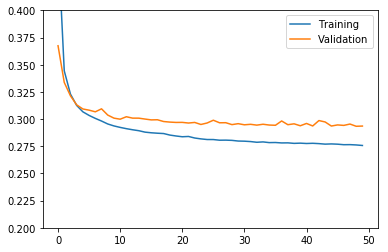

6356/6356 [==============================] - 0s 28us/step
{'loss': 0.2959130684897313, 'f_2': 0.34549571207301044, 'acc': 0.9024543737825018}


In [86]:
model_5_1 = model_5('model_5_1', nodes=15, activation='relu', optimizer='rmsprop', regularizer=1, penalty=0.001)
testmodel(model_5_1, False, 32, 0.5)

The incorporation of the L1 regularizer helped the model's validation loss maintain a greater consistency throughout the training process. Although there is overfitting (which can be alleviated with another penalty, etc.), the difference between the validation and training losses is smaller. 

The performance on the testing set is nearly exactly the same as the performance of Model 4.3. Therefore, should the L2 regularizer not offer a visible improvement, it would be quite logical to opt for this regularizer from here onwards, and perhaps fine-tune the penalty later during GSCV. 

### Model 5.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3657 - f_2: 0.1397 - acc: 0.8877 - val_loss: 0.3198 - val_f_2: 0.2959 - val_acc: 0.9036

Epoch 00001: val_loss improved from inf to 0.31976, saving model to arch_test_weights/model_5_2.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3101 - f_2: 0.3088 - acc: 0.9029 - val_loss: 0.3033 - val_f_2: 0.3045 - val_acc: 0.9030

Epoch 00002: val_loss improved from 0.31976 to 0.30326, saving model to arch_test_weights/model_5_2.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3000 - f_2: 0.3236 - acc: 0.9026 - val_loss: 0.2991 - val_f_2: 0.3464 - val_acc: 0.9030

Epoch 00003: val_loss improved from 0.30326 to 0.29914, saving model to arch_test_weights/model_5_2.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2942 - f_2: 0.3334 - acc: 0.9041 - val_loss: 0.3028 - val_f_2: 0.3017 - val_acc: 0.9027

Epoch 00004: val_loss did not improve from 0.29914
Epoch 5/50
 - 1s - loss: 0.2906 - f_2: 0.3364 - acc: 0.9038 - val_loss: 0.2941 - val_f_2: 0.3166 - val_acc: 0.


Epoch 00045: val_loss did not improve from 0.28516
Epoch 46/50
 - 1s - loss: 0.2661 - f_2: 0.4151 - acc: 0.9096 - val_loss: 0.2846 - val_f_2: 0.3855 - val_acc: 0.9025

Epoch 00046: val_loss improved from 0.28516 to 0.28463, saving model to arch_test_weights/model_5_2.best.hdf5
Epoch 47/50
 - 1s - loss: 0.2659 - f_2: 0.4168 - acc: 0.9088 - val_loss: 0.2853 - val_f_2: 0.3575 - val_acc: 0.9015

Epoch 00047: val_loss did not improve from 0.28463
Epoch 48/50
 - 1s - loss: 0.2650 - f_2: 0.4203 - acc: 0.9101 - val_loss: 0.2893 - val_f_2: 0.4082 - val_acc: 0.8989

Epoch 00048: val_loss did not improve from 0.28463
Epoch 49/50
 - 1s - loss: 0.2651 - f_2: 0.4275 - acc: 0.9102 - val_loss: 0.2888 - val_f_2: 0.3927 - val_acc: 0.9011

Epoch 00049: val_loss did not improve from 0.28463
Epoch 50/50
 - 1s - loss: 0.2648 - f_2: 0.4332 - acc: 0.9111 - val_loss: 0.2869 - val_f_2: 0.3894 - val_acc: 0.9001

Epoch 00050: val_loss did not improve from 0.28463


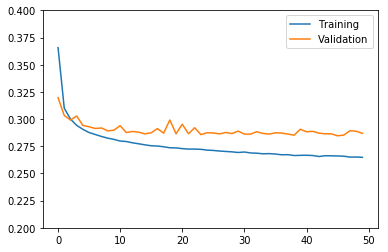

6356/6356 [==============================] - 0s 30us/step
{'loss': 0.28611334220578344, 'f_2': 0.3628580823533208, 'acc': 0.902139710434733}


In [87]:
model_5_2 = model_5('model_5_2', nodes=15, activation='relu', optimizer='rmsprop', regularizer=2, penalty=0.001)
testmodel(model_5_2, False, 32, 0.5)

From the graph above, we can infer that the L2 regularizer does not stabilize the validation loss of the model during training quite as much as the L1 regularizer does. However, the testing loss and F-2 Scores are better, and accuracy is almost exactly the same. Therefore, we can opt for the L2 regularizer over the L1.

Before concluding the exploration of the regularizers, it would be ideal to test the L2 regularizer (better performer) on a model compiled with the LR-reducer callback, to check its performance.

### Model 5.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3750 - f_2: 0.1676 - acc: 0.8832 - val_loss: 0.3269 - val_f_2: 0.3160 - val_acc: 0.9036

Epoch 00001: val_loss improved from inf to 0.32687, saving model to arch_test_weights/model_5_3.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3101 - f_2: 0.3229 - acc: 0.9032 - val_loss: 0.3064 - val_f_2: 0.3412 - val_acc: 0.9046

Epoch 00002: val_loss improved from 0.32687 to 0.30638, saving model to arch_test_weights/model_5_3.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3002 - f_2: 0.3361 - acc: 0.9037 - val_loss: 0.2999 - val_f_2: 0.3505 - val_acc: 0.9029

Epoch 00003: val_loss improved from 0.30638 to 0.29989, saving model to arch_test_weights/model_5_3.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2950 - f_2: 0.3473 - acc: 0.9043 - val_loss: 0.2962 - val_f_2: 0.3488 - val_acc: 0.9025

Epoch 00004: val_loss improved from 0.29989 to 0.29616, saving model to arch_test_weights/model_5_3.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2900 - f_2: 0.3461 - acc

 - 1s - loss: 0.2647 - f_2: 0.4178 - acc: 0.9110 - val_loss: 0.2879 - val_f_2: 0.3816 - val_acc: 0.9013

Epoch 00044: val_loss did not improve from 0.28624
Epoch 45/50
 - 1s - loss: 0.2646 - f_2: 0.4098 - acc: 0.9111 - val_loss: 0.2881 - val_f_2: 0.3802 - val_acc: 0.8997

Epoch 00045: val_loss did not improve from 0.28624
Epoch 46/50
 - 1s - loss: 0.2645 - f_2: 0.4272 - acc: 0.9112 - val_loss: 0.2880 - val_f_2: 0.3809 - val_acc: 0.9003

Epoch 00046: val_loss did not improve from 0.28624
Epoch 47/50
 - 1s - loss: 0.2645 - f_2: 0.4246 - acc: 0.9111 - val_loss: 0.2880 - val_f_2: 0.3813 - val_acc: 0.9011

Epoch 00047: val_loss did not improve from 0.28624
Epoch 48/50
 - 1s - loss: 0.2645 - f_2: 0.4136 - acc: 0.9109 - val_loss: 0.2881 - val_f_2: 0.3842 - val_acc: 0.8999

Epoch 00048: val_loss did not improve from 0.28624
Epoch 49/50
 - 1s - loss: 0.2645 - f_2: 0.4147 - acc: 0.9108 - val_loss: 0.2882 - val_f_2: 0.3884 - val_acc: 0.9003

Epoch 00049: val_loss did not improve from 0.28624
Epoc

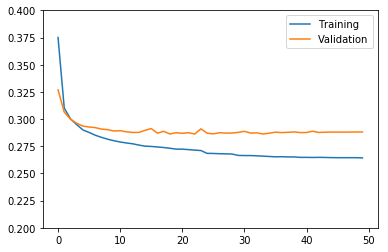

6356/6356 [==============================] - 0s 29us/step
{'loss': 0.2871230079776615, 'f_2': 0.35306039535609046, 'acc': 0.901667715469346}


In [88]:
model_5_3 = model_5('model_5_3', nodes=15, activation='relu', optimizer='rmsprop', regularizer=2, penalty=0.001)
testmodel(model_5_3, True, 32, 0.5)

The addition of the LR-reducing callback to the architecture of Model 5.2 did not substantially help our model. In fact, 'loss' increased and the F-2 Score decreased. Therefore, we can proceed to experiment with Model 5.2's architecture without using an LR-reducing callback.  

## Model 6

For model 6, we will be attempting to incorporate 1, 2, and 3 dropout layers to the network architecture, to attempt to reduce overfitting. To be conservative, we will include all the dropout layers with a drop size of 0.2. Should this be a beneficial incorporation to the model, the exact value of the drop can be tuned using GSCV later.

Because these architectures are all model-specific, we will create all the models independently, to avoid having to create 'if' statements and three separate architectures in a single method. 

### Model 6.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3790 - f_2: 0.1246 - acc: 0.8822 - val_loss: 0.3167 - val_f_2: 0.3086 - val_acc: 0.9007

Epoch 00001: val_loss improved from inf to 0.31669, saving model to arch_test_weights/model_6_1.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3152 - f_2: 0.3172 - acc: 0.9014 - val_loss: 0.3058 - val_f_2: 0.3199 - val_acc: 0.9013

Epoch 00002: val_loss improved from 0.31669 to 0.30581, saving model to arch_test_weights/model_6_1.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3039 - f_2: 0.3247 - acc: 0.9037 - val_loss: 0.2974 - val_f_2: 0.3380 - val_acc: 0.9021

Epoch 00003: val_loss improved from 0.30581 to 0.29741, saving model to arch_test_weights/model_6_1.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2971 - f_2: 0.3371 - acc: 0.9029 - val_loss: 0.2945 - val_f_2: 0.3502 - val_acc: 0.9036

Epoch 00004: val_loss improved from 0.29741 to 0.29445, saving model to arch_test_weights/model_6_1.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2932 - f_2: 0.3388 - acc


Epoch 00045: val_loss did not improve from 0.28446
Epoch 46/50
 - 1s - loss: 0.2703 - f_2: 0.4169 - acc: 0.9092 - val_loss: 0.2914 - val_f_2: 0.4022 - val_acc: 0.8993

Epoch 00046: val_loss did not improve from 0.28446
Epoch 47/50
 - 1s - loss: 0.2704 - f_2: 0.4076 - acc: 0.9097 - val_loss: 0.2885 - val_f_2: 0.3884 - val_acc: 0.9015

Epoch 00047: val_loss did not improve from 0.28446
Epoch 48/50
 - 1s - loss: 0.2709 - f_2: 0.4169 - acc: 0.9095 - val_loss: 0.2944 - val_f_2: 0.4517 - val_acc: 0.8973

Epoch 00048: val_loss did not improve from 0.28446
Epoch 49/50
 - 1s - loss: 0.2702 - f_2: 0.4157 - acc: 0.9085 - val_loss: 0.2899 - val_f_2: 0.3954 - val_acc: 0.8999

Epoch 00049: val_loss did not improve from 0.28446
Epoch 50/50
 - 1s - loss: 0.2701 - f_2: 0.4171 - acc: 0.9100 - val_loss: 0.2910 - val_f_2: 0.3605 - val_acc: 0.9019

Epoch 00050: val_loss did not improve from 0.28446


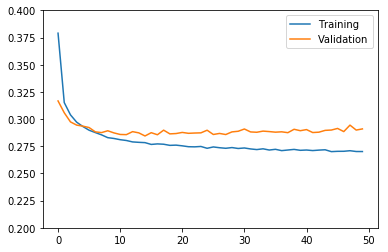

6356/6356 [==============================] - 0s 31us/step
{'loss': 0.2863150975702693, 'f_2': 0.37505489286020155, 'acc': 0.9044996852616681}


In [91]:
def model_6_1(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_6_1 = model_6_1('model_6_1', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_6_1, False, 32, 0.5)

The results of this experiment are positive: for one, we can see how the L2 regularizer keeps 'stabilizing' the validation loss; secondly, the testing loss is at a minimum value, while the F-2 and accuracy scores are at their maximum (until now). Furthermore, there is evidence of the training and validation losses treading a bit closer to each other as the number of epochs progresses.

Let's attempt to see how the model performs with two dropout layers.

### Model 6.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3921 - f_2: 0.0047 - acc: 0.8726 - val_loss: 0.3444 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 0.34436, saving model to arch_test_weights/model_6_2.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3396 - f_2: 0.1294 - acc: 0.8851 - val_loss: 0.3281 - val_f_2: 0.2671 - val_acc: 0.8995

Epoch 00002: val_loss improved from 0.34436 to 0.32806, saving model to arch_test_weights/model_6_2.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3261 - f_2: 0.2698 - acc: 0.8994 - val_loss: 0.3271 - val_f_2: 0.3045 - val_acc: 0.9017

Epoch 00003: val_loss improved from 0.32806 to 0.32705, saving model to arch_test_weights/model_6_2.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3187 - f_2: 0.3072 - acc: 0.9020 - val_loss: 0.3135 - val_f_2: 0.3102 - val_acc: 0.9019

Epoch 00004: val_loss improved from 0.32705 to 0.31345, saving model to arch_test_weights/model_6_2.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3142 - f_2: 0.3099 - acc


Epoch 00043: val_loss did not improve from 0.28709
Epoch 44/50
 - 1s - loss: 0.2756 - f_2: 0.4230 - acc: 0.9094 - val_loss: 0.2926 - val_f_2: 0.4213 - val_acc: 0.8987

Epoch 00044: val_loss did not improve from 0.28709
Epoch 45/50
 - 1s - loss: 0.2749 - f_2: 0.4303 - acc: 0.9094 - val_loss: 0.2896 - val_f_2: 0.4076 - val_acc: 0.9015

Epoch 00045: val_loss did not improve from 0.28709
Epoch 46/50
 - 1s - loss: 0.2744 - f_2: 0.4261 - acc: 0.9104 - val_loss: 0.2899 - val_f_2: 0.4095 - val_acc: 0.9017

Epoch 00046: val_loss did not improve from 0.28709
Epoch 47/50
 - 1s - loss: 0.2753 - f_2: 0.4312 - acc: 0.9103 - val_loss: 0.2933 - val_f_2: 0.4134 - val_acc: 0.8991

Epoch 00047: val_loss did not improve from 0.28709
Epoch 48/50
 - 1s - loss: 0.2757 - f_2: 0.4220 - acc: 0.9098 - val_loss: 0.2892 - val_f_2: 0.3655 - val_acc: 0.9003

Epoch 00048: val_loss did not improve from 0.28709
Epoch 49/50
 - 1s - loss: 0.2741 - f_2: 0.4226 - acc: 0.9099 - val_loss: 0.2905 - val_f_2: 0.3686 - val_acc:

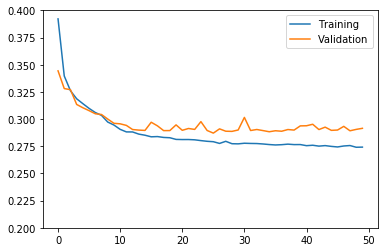

6356/6356 [==============================] - 0s 39us/step
{'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}


In [93]:
def model_6_2(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_6_2 = model_6_2('model_6_2', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_6_2, False, 32, 0.5)

The results of this particular experiment are mixed: The testing loss of the model increased very slightly, in comparison to Model 6.2's, the accuracy decreased slightly, too; on the upside, however, we have attained the highest F-2 Score until now, and the model seems to be reducing overfitting, since the validation loss and training loss seem to be coming closer together as the number of epochs increases. 

If three dropout layers don't improve performance, then it is preferable to have 2 than 1. 

### Model 6.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.4047 - f_2: 0.0231 - acc: 0.8638 - val_loss: 0.3475 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 0.34749, saving model to arch_test_weights/model_6_3.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3423 - f_2: 0.0157 - acc: 0.8726 - val_loss: 0.3303 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00002: val_loss improved from 0.34749 to 0.33031, saving model to arch_test_weights/model_6_3.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3321 - f_2: 0.1183 - acc: 0.8841 - val_loss: 0.3239 - val_f_2: 0.2402 - val_acc: 0.8968

Epoch 00003: val_loss improved from 0.33031 to 0.32388, saving model to arch_test_weights/model_6_3.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3268 - f_2: 0.2257 - acc: 0.8956 - val_loss: 0.3174 - val_f_2: 0.2864 - val_acc: 0.9019

Epoch 00004: val_loss improved from 0.32388 to 0.31743, saving model to arch_test_weights/model_6_3.best.hdf5
Epoch 5/50
 - 1s - loss: 0.3199 - f_2: 0.2643 - acc


Epoch 00044: val_loss did not improve from 0.29912
Epoch 45/50
 - 1s - loss: 0.2936 - f_2: 0.3997 - acc: 0.9056 - val_loss: 0.3019 - val_f_2: 0.4215 - val_acc: 0.9021

Epoch 00045: val_loss did not improve from 0.29912
Epoch 46/50
 - 1s - loss: 0.2942 - f_2: 0.4077 - acc: 0.9060 - val_loss: 0.3015 - val_f_2: 0.3935 - val_acc: 0.9044

Epoch 00046: val_loss did not improve from 0.29912
Epoch 47/50
 - 1s - loss: 0.2943 - f_2: 0.3938 - acc: 0.9053 - val_loss: 0.3045 - val_f_2: 0.3723 - val_acc: 0.9025

Epoch 00047: val_loss did not improve from 0.29912
Epoch 48/50
 - 1s - loss: 0.2923 - f_2: 0.3886 - acc: 0.9051 - val_loss: 0.3018 - val_f_2: 0.4262 - val_acc: 0.9013

Epoch 00048: val_loss did not improve from 0.29912
Epoch 49/50
 - 1s - loss: 0.2940 - f_2: 0.4095 - acc: 0.9046 - val_loss: 0.3048 - val_f_2: 0.4140 - val_acc: 0.9036

Epoch 00049: val_loss did not improve from 0.29912
Epoch 50/50
 - 1s - loss: 0.2957 - f_2: 0.4051 - acc: 0.9046 - val_loss: 0.3059 - val_f_2: 0.4362 - val_acc:

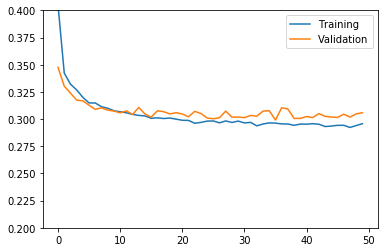

6356/6356 [==============================] - 0s 32us/step
{'loss': 0.295878173852582, 'f_2': 0.3732975859128609, 'acc': 0.9040276903337919}


In [95]:
def model_6_3(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 3rd dropout layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_6_3 = model_6_3('model_6_3', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_6_3, False, 32, 0.5)

The performance of the model with 3 dropout layers is satisfactory but raises important questions. Overfitting seems to have decreased from the performance of model 6.2 (validation loss and training loss have converged significantly more), the testing accuracy increased, but the testing loss increased and the F-2 Score both decreased. 

To settle this matter, it would be interesting to evaluate the models' (6.2 and 6.3) performances without the kernel regularizer. This would seem like going back in this process of increasing performance, but since a regularizer is essentially one of the 'bells and whistles' that can be incorporated in a model, it is significant to analyze how the model performs without them after having incorporated the dropout layers. 

## Model 7

For the Model 7 architectures, I will be removing the kernel regularizers for architectures with both 2 and 3 dropout layers. 

Like the Model 6 architectures, these architectures are case-specific, and therefore to avoid having to construct a complicated if-statement with two alternatives, I will simply construct each architecture specifically.

### Model 7.1

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 2s - loss: 0.3544 - f_2: 0.0523 - acc: 0.8765 - val_loss: 0.3123 - val_f_2: 0.2663 - val_acc: 0.8995

Epoch 00001: val_loss improved from inf to 0.31228, saving model to arch_test_weights/model_7_1.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3048 - f_2: 0.2793 - acc: 0.8986 - val_loss: 0.2906 - val_f_2: 0.3401 - val_acc: 0.9021

Epoch 00002: val_loss improved from 0.31228 to 0.29060, saving model to arch_test_weights/model_7_1.best.hdf5
Epoch 3/50
 - 1s - loss: 0.2897 - f_2: 0.3239 - acc: 0.9014 - val_loss: 0.2893 - val_f_2: 0.3495 - val_acc: 0.9017

Epoch 00003: val_loss improved from 0.29060 to 0.28928, saving model to arch_test_weights/model_7_1.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2861 - f_2: 0.3217 - acc: 0.9029 - val_loss: 0.2865 - val_f_2: 0.3033 - val_acc: 0.9017

Epoch 00004: val_loss improved from 0.28928 to 0.28650, saving model to arch_test_weights/model_7_1.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2831 - f_2: 0.3289 - acc

 - 1s - loss: 0.2657 - f_2: 0.4153 - acc: 0.9104 - val_loss: 0.3008 - val_f_2: 0.3941 - val_acc: 0.9050

Epoch 00047: val_loss did not improve from 0.28080
Epoch 48/50
 - 1s - loss: 0.2656 - f_2: 0.3991 - acc: 0.9089 - val_loss: 0.2988 - val_f_2: 0.4120 - val_acc: 0.9029

Epoch 00048: val_loss did not improve from 0.28080
Epoch 49/50
 - 1s - loss: 0.2654 - f_2: 0.4324 - acc: 0.9096 - val_loss: 0.2968 - val_f_2: 0.4003 - val_acc: 0.9048

Epoch 00049: val_loss did not improve from 0.28080
Epoch 50/50
 - 1s - loss: 0.2644 - f_2: 0.4222 - acc: 0.9102 - val_loss: 0.3023 - val_f_2: 0.4161 - val_acc: 0.9036

Epoch 00050: val_loss did not improve from 0.28080


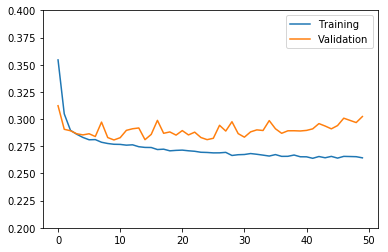

6356/6356 [==============================] - 0s 32us/step
{'loss': 0.2850387147794811, 'f_2': 0.34133235411431795, 'acc': 0.9040276902962812}


In [96]:
# 2 dropout layers, no regularizers
def model_7_1(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation))
    model.add(Dropout(0.2)) 
    model.add(Dense(nodes + 5, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(nodes + 10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_7_1 = model_7_1('model_7_1', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_7_1, False, 32, 0.5)

The results of this experimentation are not satisfactory: the testing loss did decrease compared to model 6.2 and the accuracy increased a little bit, but the F-2 score dropped more significantly. Furthermore, the model seems to be overfitting more, judging by the graph above. 

Let's explore how the absence of the kernel regularizers affects the model architecture with 3 dropouts.

### Model 7.2

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.3532 - f_2: 0.0982 - acc: 0.8795 - val_loss: 0.3001 - val_f_2: 0.2930 - val_acc: 0.9015

Epoch 00001: val_loss improved from inf to 0.30006, saving model to arch_test_weights/model_7_2.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3062 - f_2: 0.2880 - acc: 0.8991 - val_loss: 0.2872 - val_f_2: 0.3074 - val_acc: 0.9019

Epoch 00002: val_loss improved from 0.30006 to 0.28724, saving model to arch_test_weights/model_7_2.best.hdf5
Epoch 3/50
 - 1s - loss: 0.2970 - f_2: 0.3138 - acc: 0.9032 - val_loss: 0.2838 - val_f_2: 0.3137 - val_acc: 0.9029

Epoch 00003: val_loss improved from 0.28724 to 0.28379, saving model to arch_test_weights/model_7_2.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2915 - f_2: 0.3205 - acc: 0.9038 - val_loss: 0.2867 - val_f_2: 0.3623 - val_acc: 0.9032

Epoch 00004: val_loss did not improve from 0.28379
Epoch 5/50
 - 1s - loss: 0.2879 - f_2: 0.3263 - acc: 0.9031 - val_loss: 0.2823 - val_f_2: 0.3348 - val_acc: 0.


Epoch 00047: val_loss did not improve from 0.28037
Epoch 48/50
 - 1s - loss: 0.2671 - f_2: 0.4133 - acc: 0.9085 - val_loss: 0.2924 - val_f_2: 0.4172 - val_acc: 0.9015

Epoch 00048: val_loss did not improve from 0.28037
Epoch 49/50
 - 1s - loss: 0.2658 - f_2: 0.4193 - acc: 0.9098 - val_loss: 0.3008 - val_f_2: 0.4330 - val_acc: 0.9015

Epoch 00049: val_loss did not improve from 0.28037
Epoch 50/50
 - 1s - loss: 0.2683 - f_2: 0.4158 - acc: 0.9084 - val_loss: 0.2918 - val_f_2: 0.4268 - val_acc: 0.9013

Epoch 00050: val_loss did not improve from 0.28037


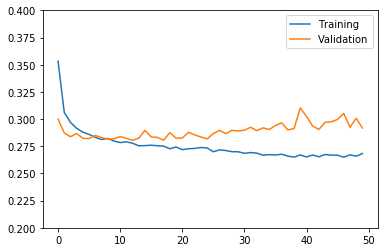

6356/6356 [==============================] - 0s 31us/step
{'loss': 0.28397302279838454, 'f_2': 0.3195492145872192, 'acc': 0.9035556953308941}


In [97]:
# 3 dropout layers, no regularizers
def model_7_2(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation))
    model.add(Dropout(0.2)) 
    model.add(Dense(nodes + 5, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(nodes + 10, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_7_2 = model_7_2('model_7_2', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_7_2, False, 32, 0.5)

The performance of this last model makes it clear that the kernel regularizers are necessary: the testing loss did decrease compared to model 6.3 (3 dropouts + regularizer), but the F-2 score dropped significantly. The accuracy score also decreased somewhat. 

Finally, to rule out the possibility of the model with one dropout performing well without the regularizer, we will test the possibility for model 7.3. However, since it is evident that the regularizer helps reduce overfitting, less dropout layers will only increase it. The prevailing hypothesis is therefore that this model will not perform well. 

### Model 7.3

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.3488 - f_2: 0.0938 - acc: 0.8764 - val_loss: 0.3011 - val_f_2: 0.2893 - val_acc: 0.8997

Epoch 00001: val_loss improved from inf to 0.30109, saving model to arch_test_weights/model_7_3.best.hdf5
Epoch 2/50
 - 1s - loss: 0.2939 - f_2: 0.3088 - acc: 0.9016 - val_loss: 0.2891 - val_f_2: 0.3391 - val_acc: 0.9030

Epoch 00002: val_loss improved from 0.30109 to 0.28914, saving model to arch_test_weights/model_7_3.best.hdf5
Epoch 3/50
 - 1s - loss: 0.2865 - f_2: 0.3267 - acc: 0.9035 - val_loss: 0.2865 - val_f_2: 0.3797 - val_acc: 0.9034

Epoch 00003: val_loss improved from 0.28914 to 0.28648, saving model to arch_test_weights/model_7_3.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2825 - f_2: 0.3396 - acc: 0.9033 - val_loss: 0.2849 - val_f_2: 0.3439 - val_acc: 0.9030

Epoch 00004: val_loss improved from 0.28648 to 0.28491, saving model to arch_test_weights/model_7_3.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2794 - f_2: 0.3488 - acc


Epoch 00047: val_loss did not improve from 0.28220
Epoch 48/50
 - 1s - loss: 0.2625 - f_2: 0.4183 - acc: 0.9104 - val_loss: 0.2890 - val_f_2: 0.3598 - val_acc: 0.9023

Epoch 00048: val_loss did not improve from 0.28220
Epoch 49/50
 - 1s - loss: 0.2629 - f_2: 0.4130 - acc: 0.9099 - val_loss: 0.2945 - val_f_2: 0.4532 - val_acc: 0.9005

Epoch 00049: val_loss did not improve from 0.28220
Epoch 50/50
 - 1s - loss: 0.2627 - f_2: 0.4125 - acc: 0.9116 - val_loss: 0.2900 - val_f_2: 0.3990 - val_acc: 0.9029

Epoch 00050: val_loss did not improve from 0.28220


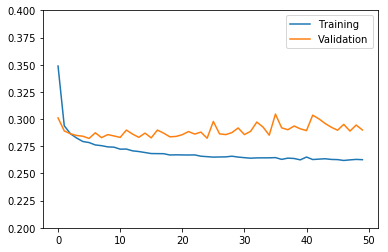

6356/6356 [==============================] - 0s 30us/step
{'loss': 0.2833786641111008, 'f_2': 0.32129801620682985, 'acc': 0.9033983637132759}


In [98]:
# 1 dropout layer, no regularizers
def model_7_3(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(nodes + 5, activation=activation))
    model.add(Dense(nodes + 10, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

model_7_3 = model_7_3('model_7_3', nodes=15, activation='relu', optimizer='rmsprop')
testmodel(model_7_3, False, 32, 0.5)

The futility of the above experiment is self-evident, and does not need to be commented. Therefore, we can proceed with the advancement of the more fruitful axes of our analyis.


Therefore, the question then becomes: How many dropouts? 2 or 3? The accuracy is higher for the model with 3 dropouts, and the model seems to overfit less. However, the F-2 Score is significantly higher for the model with 2 dropouts and the testing loss is lower. The best solution to this predicament is to continue testing the next implementations on both of those two models, and judge the better performer by the further tweaks that are performed.  

## Model 8

In this Model, we will test changes on the two alternatives for the number of dropouts (2 and 3), both equipped with kernel regularizers. For the sake of clarity, we will remove the version X.1 from here forth, so that only X.2 and X.3 remain. This makes it more understandable, since it will be inferred that X.2 and X.3 refer to the model architectures with 2 dropout and 3 dropout layers, respectively. 

For this generation of models, we will attempt to change the optimizer to 'adam', 'adamax', 'nadam', and 'adagrad', to observe their performance and find the one that works best with each. 

### Model 8.2

In [105]:
def model_8_2(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

#### Adam

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.3935 - f_2: 0.0830 - acc: 0.8738 - val_loss: 0.3184 - val_f_2: 0.3167 - val_acc: 0.9009

Epoch 00001: val_loss improved from inf to 0.31839, saving model to arch_test_weights/model_8_2_adam.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3196 - f_2: 0.3184 - acc: 0.9003 - val_loss: 0.3011 - val_f_2: 0.3584 - val_acc: 0.9017

Epoch 00002: val_loss improved from 0.31839 to 0.30108, saving model to arch_test_weights/model_8_2_adam.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3055 - f_2: 0.3210 - acc: 0.9019 - val_loss: 0.2961 - val_f_2: 0.3012 - val_acc: 0.9019

Epoch 00003: val_loss improved from 0.30108 to 0.29612, saving model to arch_test_weights/model_8_2_adam.best.hdf5
Epoch 4/50
 - 1s - loss: 0.2993 - f_2: 0.3305 - acc: 0.9040 - val_loss: 0.2937 - val_f_2: 0.3320 - val_acc: 0.9013

Epoch 00004: val_loss improved from 0.29612 to 0.29375, saving model to arch_test_weights/model_8_2_adam.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2937

 - 2s - loss: 0.2651 - f_2: 0.4119 - acc: 0.9087 - val_loss: 0.2845 - val_f_2: 0.3991 - val_acc: 0.8993

Epoch 00045: val_loss did not improve from 0.28367
Epoch 46/50
 - 1s - loss: 0.2666 - f_2: 0.3989 - acc: 0.9099 - val_loss: 0.2849 - val_f_2: 0.3738 - val_acc: 0.8971

Epoch 00046: val_loss did not improve from 0.28367
Epoch 47/50
 - 2s - loss: 0.2649 - f_2: 0.4020 - acc: 0.9070 - val_loss: 0.2876 - val_f_2: 0.3615 - val_acc: 0.8997

Epoch 00047: val_loss did not improve from 0.28367
Epoch 48/50
 - 1s - loss: 0.2648 - f_2: 0.4070 - acc: 0.9087 - val_loss: 0.2841 - val_f_2: 0.3627 - val_acc: 0.9009

Epoch 00048: val_loss did not improve from 0.28367
Epoch 49/50
 - 1s - loss: 0.2645 - f_2: 0.4059 - acc: 0.9097 - val_loss: 0.2867 - val_f_2: 0.3867 - val_acc: 0.8973

Epoch 00049: val_loss did not improve from 0.28367
Epoch 50/50
 - 1s - loss: 0.2659 - f_2: 0.3942 - acc: 0.9093 - val_loss: 0.2867 - val_f_2: 0.3959 - val_acc: 0.8973

Epoch 00050: val_loss did not improve from 0.28367


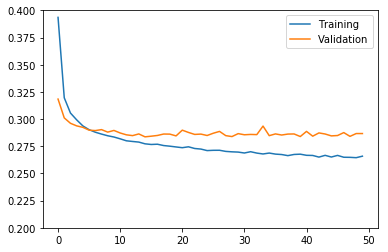

6356/6356 [==============================] - 0s 38us/step
{'loss': 0.2867778639248739, 'f_2': 0.3340178116988281, 'acc': 0.9029263687478888}


In [106]:
model_8_2_adam = model_8_2('model_8_2_adam', nodes=15, activation='relu', optimizer='adam')
testmodel(model_8_2_adam, False, 32, 0.5)

Model 6.2's results (sambe but with 'rmsprop'):
{'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}

Compared to Model 6.2's performance, the performance of Model 8.2 is very similar. However, accuracy decreased and the F-2 Score dropped, so RMSprop seems to be the better one at this point. 

So far, Adam < RMSprop

#### Adamax

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.4081 - f_2: 0.0184 - acc: 0.8714 - val_loss: 0.3667 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 0.36673, saving model to arch_test_weights/model_8_2_adamax.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3565 - f_2: 0.0347 - acc: 0.8757 - val_loss: 0.3394 - val_f_2: 0.2154 - val_acc: 0.8938

Epoch 00002: val_loss improved from 0.36673 to 0.33942, saving model to arch_test_weights/model_8_2_adamax.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3385 - f_2: 0.2265 - acc: 0.8946 - val_loss: 0.3224 - val_f_2: 0.3118 - val_acc: 0.9025

Epoch 00003: val_loss improved from 0.33942 to 0.32243, saving model to arch_test_weights/model_8_2_adamax.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3212 - f_2: 0.2769 - acc: 0.8967 - val_loss: 0.3094 - val_f_2: 0.3350 - val_acc: 0.9021

Epoch 00004: val_loss improved from 0.32243 to 0.30945, saving model to arch_test_weights/model_8_2_adamax.best.hdf5
Epoch 5/50
 - 2s - loss

 - 1s - loss: 0.2729 - f_2: 0.4174 - acc: 0.9078 - val_loss: 0.2861 - val_f_2: 0.3562 - val_acc: 0.8999

Epoch 00042: val_loss did not improve from 0.28522
Epoch 43/50
 - 1s - loss: 0.2723 - f_2: 0.4298 - acc: 0.9095 - val_loss: 0.2862 - val_f_2: 0.3709 - val_acc: 0.9009

Epoch 00043: val_loss did not improve from 0.28522
Epoch 44/50
 - 2s - loss: 0.2722 - f_2: 0.4218 - acc: 0.9086 - val_loss: 0.2855 - val_f_2: 0.3694 - val_acc: 0.9019

Epoch 00044: val_loss did not improve from 0.28522
Epoch 45/50
 - 2s - loss: 0.2718 - f_2: 0.4242 - acc: 0.9088 - val_loss: 0.2851 - val_f_2: 0.3539 - val_acc: 0.9011

Epoch 00045: val_loss improved from 0.28522 to 0.28506, saving model to arch_test_weights/model_8_2_adamax.best.hdf5
Epoch 46/50
 - 2s - loss: 0.2716 - f_2: 0.4219 - acc: 0.9081 - val_loss: 0.2851 - val_f_2: 0.3572 - val_acc: 0.9007

Epoch 00046: val_loss did not improve from 0.28506
Epoch 47/50
 - 1s - loss: 0.2718 - f_2: 0.4130 - acc: 0.9087 - val_loss: 0.2875 - val_f_2: 0.3965 - val_ac

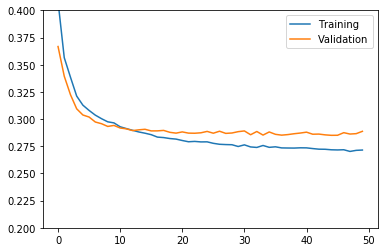

6356/6356 [==============================] - 0s 38us/step
{'loss': 0.2852860417585091, 'f_2': 0.3664645750652933, 'acc': 0.9035556953684049}


In [108]:
model_8_2_adamax = model_8_2('model_8_2_adamax', nodes=15, activation='relu', optimizer='adamax')
testmodel(model_8_2_adamax, False, 32, 0.5)

Model X.2 (RMSProp): {'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}

Compared to the model usig RMSprop, the model using Adamax barely shows any improvements in test statistics. In fact, only the test loss seems to improve. Aside from that, the lines seem to get closer, suggesting less evidence of overfitting. Still, however, RMSProp seems to be better. 

Adamax, Adam < RMSprop

#### Nadam

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3616 - f_2: 0.1780 - acc: 0.8823 - val_loss: 0.3058 - val_f_2: 0.3197 - val_acc: 0.9034

Epoch 00001: val_loss improved from inf to 0.30577, saving model to arch_test_weights/model_8_2_nadam.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3043 - f_2: 0.3224 - acc: 0.9035 - val_loss: 0.2960 - val_f_2: 0.3541 - val_acc: 0.9050

Epoch 00002: val_loss improved from 0.30577 to 0.29599, saving model to arch_test_weights/model_8_2_nadam.best.hdf5
Epoch 3/50
 - 2s - loss: 0.2939 - f_2: 0.3416 - acc: 0.9042 - val_loss: 0.2910 - val_f_2: 0.3079 - val_acc: 0.9029

Epoch 00003: val_loss improved from 0.29599 to 0.29096, saving model to arch_test_weights/model_8_2_nadam.best.hdf5
Epoch 4/50
 - 2s - loss: 0.2873 - f_2: 0.3461 - acc: 0.9036 - val_loss: 0.2927 - val_f_2: 0.4129 - val_acc: 0.8987

Epoch 00004: val_loss did not improve from 0.29096
Epoch 5/50
 - 2s - loss: 0.2846 - f_2: 0.3478 - acc: 0.9043 - val_loss: 0.2853 - val_f_2: 0.


Epoch 00045: val_loss did not improve from 0.27949
Epoch 46/50
 - 2s - loss: 0.2649 - f_2: 0.4243 - acc: 0.9106 - val_loss: 0.2839 - val_f_2: 0.3898 - val_acc: 0.8995

Epoch 00046: val_loss did not improve from 0.27949
Epoch 47/50
 - 2s - loss: 0.2643 - f_2: 0.4327 - acc: 0.9110 - val_loss: 0.2823 - val_f_2: 0.3897 - val_acc: 0.9034

Epoch 00047: val_loss did not improve from 0.27949
Epoch 48/50
 - 2s - loss: 0.2654 - f_2: 0.4263 - acc: 0.9089 - val_loss: 0.2889 - val_f_2: 0.3567 - val_acc: 0.9017

Epoch 00048: val_loss did not improve from 0.27949
Epoch 49/50
 - 2s - loss: 0.2656 - f_2: 0.4272 - acc: 0.9111 - val_loss: 0.2842 - val_f_2: 0.4047 - val_acc: 0.8993

Epoch 00049: val_loss did not improve from 0.27949
Epoch 50/50
 - 2s - loss: 0.2653 - f_2: 0.4242 - acc: 0.9098 - val_loss: 0.2864 - val_f_2: 0.3601 - val_acc: 0.9011

Epoch 00050: val_loss did not improve from 0.27949


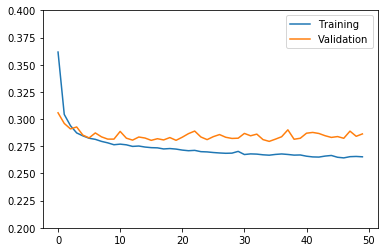

6356/6356 [==============================] - 0s 37us/step
{'loss': 0.2830307256545264, 'f_2': 0.36706863874735074, 'acc': 0.9041850219889209}


In [110]:
model_8_2_nadam = model_8_2('model_8_2_nadam', nodes=15, activation='relu', optimizer='nadam')
testmodel(model_8_2_nadam, False, 32, 0.5)

Model X.2 (RMSProp): {'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}

Compared to the statistics obtained by the model using RMSProp as the optimizer, Nadam's statistics arent that better. Accuracy improves slightly and so does the validation score, but the F-2 Score is a farther below. However, because the validation loss of the model using RMSprop was steadier (smoother learning) I am inclined in favor of RMSProp instead. 

Nadam, Adamax, Adam < RMSProp

#### Adagrad

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 3s - loss: 0.3813 - f_2: 0.0477 - acc: 0.8759 - val_loss: 0.3407 - val_f_2: 0.2246 - val_acc: 0.8950

Epoch 00001: val_loss improved from inf to 0.34075, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3416 - f_2: 0.2169 - acc: 0.8928 - val_loss: 0.3196 - val_f_2: 0.3195 - val_acc: 0.9044

Epoch 00002: val_loss improved from 0.34075 to 0.31956, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3261 - f_2: 0.2997 - acc: 0.9002 - val_loss: 0.3116 - val_f_2: 0.3117 - val_acc: 0.9036

Epoch 00003: val_loss improved from 0.31956 to 0.31160, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3172 - f_2: 0.3166 - acc: 0.9012 - val_loss: 0.3074 - val_f_2: 0.3243 - val_acc: 0.9023

Epoch 00004: val_loss improved from 0.31160 to 0.30737, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 5/50
 - 1s - 

 - 1s - loss: 0.2878 - f_2: 0.3592 - acc: 0.9055 - val_loss: 0.2890 - val_f_2: 0.3350 - val_acc: 0.9027

Epoch 00036: val_loss did not improve from 0.28878
Epoch 37/50
 - 1s - loss: 0.2890 - f_2: 0.3368 - acc: 0.9035 - val_loss: 0.2886 - val_f_2: 0.3403 - val_acc: 0.9023

Epoch 00037: val_loss improved from 0.28878 to 0.28864, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 38/50
 - 1s - loss: 0.2873 - f_2: 0.3422 - acc: 0.9054 - val_loss: 0.2885 - val_f_2: 0.3480 - val_acc: 0.9027

Epoch 00038: val_loss improved from 0.28864 to 0.28853, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 39/50
 - 1s - loss: 0.2876 - f_2: 0.3490 - acc: 0.9044 - val_loss: 0.2883 - val_f_2: 0.3446 - val_acc: 0.9027

Epoch 00039: val_loss improved from 0.28853 to 0.28833, saving model to arch_test_weights/model_8_2_adagrad.best.hdf5
Epoch 40/50
 - 1s - loss: 0.2856 - f_2: 0.3497 - acc: 0.9054 - val_loss: 0.2884 - val_f_2: 0.3411 - val_acc: 0.9021

Epoch 00040: val_loss 

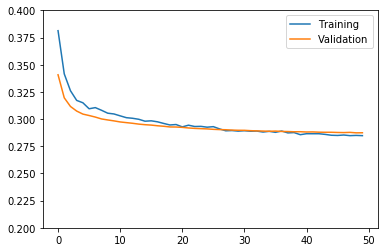

6356/6356 [==============================] - 0s 40us/step
{'loss': 0.28967560806163384, 'f_2': 0.34035185663650613, 'acc': 0.9005663939209536}


In [111]:
model_8_2_adagrad = model_8_2('model_8_2_adagrad', nodes=15, activation='relu', optimizer='adagrad')
testmodel(model_8_2_adagrad, False, 32, 0.5)

Model X.2 (RMSProp): {'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}

Model X.2 using Adagrad is one of the smoothest-learning models observed up until now. The training and validation losses converge quite nicely, and seem to have overcome the frequent problem of overfitting rather well. 

However, the statistics obtained by the model show barely any improvement in the actual testing loss, and instead show a worsening performance in accuracy. Therefore, RMSProp remains the preferable activation function. 

Adagrad, Nadam, Adamax, Adam < RMSProp for model X.2

### Model 8.3

In [107]:
def model_8_3(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 3rd dropout layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

#### Adam

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3990 - f_2: 0.0599 - acc: 0.8759 - val_loss: 0.3319 - val_f_2: 0.2780 - val_acc: 0.9003

Epoch 00001: val_loss improved from inf to 0.33192, saving model to arch_test_weights/model_8_3_adam.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3268 - f_2: 0.2650 - acc: 0.8954 - val_loss: 0.3060 - val_f_2: 0.3687 - val_acc: 0.9013

Epoch 00002: val_loss improved from 0.33192 to 0.30596, saving model to arch_test_weights/model_8_3_adam.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3116 - f_2: 0.3175 - acc: 0.9010 - val_loss: 0.2976 - val_f_2: 0.3221 - val_acc: 0.9013

Epoch 00003: val_loss improved from 0.30596 to 0.29764, saving model to arch_test_weights/model_8_3_adam.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3023 - f_2: 0.3251 - acc: 0.9028 - val_loss: 0.2926 - val_f_2: 0.3259 - val_acc: 0.9030

Epoch 00004: val_loss improved from 0.29764 to 0.29258, saving model to arch_test_weights/model_8_3_adam.best.hdf5
Epoch 5/50
 - 2s - loss: 0.2954


Epoch 00045: val_loss did not improve from 0.28144
Epoch 46/50
 - 1s - loss: 0.2703 - f_2: 0.4118 - acc: 0.9093 - val_loss: 0.2824 - val_f_2: 0.3592 - val_acc: 0.9025

Epoch 00046: val_loss did not improve from 0.28144
Epoch 47/50
 - 2s - loss: 0.2702 - f_2: 0.3970 - acc: 0.9074 - val_loss: 0.2864 - val_f_2: 0.3767 - val_acc: 0.9001

Epoch 00047: val_loss did not improve from 0.28144
Epoch 48/50
 - 2s - loss: 0.2713 - f_2: 0.3916 - acc: 0.9071 - val_loss: 0.2828 - val_f_2: 0.4057 - val_acc: 0.8993

Epoch 00048: val_loss did not improve from 0.28144
Epoch 49/50
 - 2s - loss: 0.2702 - f_2: 0.3995 - acc: 0.9079 - val_loss: 0.2825 - val_f_2: 0.4354 - val_acc: 0.8991

Epoch 00049: val_loss did not improve from 0.28144
Epoch 50/50
 - 1s - loss: 0.2705 - f_2: 0.4099 - acc: 0.9077 - val_loss: 0.2864 - val_f_2: 0.4316 - val_acc: 0.8960

Epoch 00050: val_loss did not improve from 0.28144


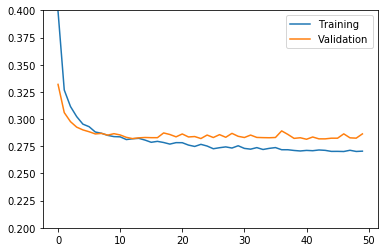

6356/6356 [==============================] - 0s 38us/step
{'loss': 0.2840201926538973, 'f_2': 0.3858319894921484, 'acc': 0.9008810572312117}


In [109]:
model_8_3_adam = model_8_3('model_8_3_adam', nodes=15, activation='relu', optimizer='adam')
testmodel(model_8_3_adam, False, 32, 0.5)

Model 6.3's performance (same but with 'rmsprop' as optimizer):
{'loss': 0.295878173852582, 'f_2': 0.3732975859128609, 'acc': 0.9040276903337919}

In comparison to Model 6.3, Model 8.3 reduced the testing loss (and accuracy) by a slight margin, and it increased the F-2 Score by a large margin. In addition, the training and validation losses seem to approximate at a lower value than it occured in Model 6.3's training. Therefore, I would suggest Adam is better for this architecture.

RMSProp < Adam

#### Adamax

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.4137 - f_2: 0.0191 - acc: 0.8714 - val_loss: 0.3515 - val_f_2: 0.1167 - val_acc: 0.8816

Epoch 00001: val_loss improved from inf to 0.35152, saving model to arch_test_weights/model_8_3_adamax.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3468 - f_2: 0.2199 - acc: 0.8934 - val_loss: 0.3215 - val_f_2: 0.3112 - val_acc: 0.9019

Epoch 00002: val_loss improved from 0.35152 to 0.32151, saving model to arch_test_weights/model_8_3_adamax.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3260 - f_2: 0.3059 - acc: 0.9001 - val_loss: 0.3104 - val_f_2: 0.3208 - val_acc: 0.9021

Epoch 00003: val_loss improved from 0.32151 to 0.31043, saving model to arch_test_weights/model_8_3_adamax.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3176 - f_2: 0.3119 - acc: 0.9005 - val_loss: 0.3062 - val_f_2: 0.3394 - val_acc: 0.9009

Epoch 00004: val_loss improved from 0.31043 to 0.30620, saving model to arch_test_weights/model_8_3_adamax.best.hdf5
Epoch 5/50
 - 2s - loss


Epoch 00040: val_loss did not improve from 0.28144
Epoch 41/50
 - 2s - loss: 0.2734 - f_2: 0.3862 - acc: 0.9060 - val_loss: 0.2810 - val_f_2: 0.3586 - val_acc: 0.9003

Epoch 00041: val_loss improved from 0.28144 to 0.28099, saving model to arch_test_weights/model_8_3_adamax.best.hdf5
Epoch 42/50
 - 2s - loss: 0.2732 - f_2: 0.3906 - acc: 0.9058 - val_loss: 0.2822 - val_f_2: 0.4150 - val_acc: 0.9025

Epoch 00042: val_loss did not improve from 0.28099
Epoch 43/50
 - 2s - loss: 0.2719 - f_2: 0.3889 - acc: 0.9065 - val_loss: 0.2832 - val_f_2: 0.3961 - val_acc: 0.9013

Epoch 00043: val_loss did not improve from 0.28099
Epoch 44/50
 - 2s - loss: 0.2728 - f_2: 0.3749 - acc: 0.9040 - val_loss: 0.2811 - val_f_2: 0.3590 - val_acc: 0.9013

Epoch 00044: val_loss did not improve from 0.28099
Epoch 45/50
 - 2s - loss: 0.2733 - f_2: 0.3753 - acc: 0.9045 - val_loss: 0.2826 - val_f_2: 0.4066 - val_acc: 0.9015

Epoch 00045: val_loss did not improve from 0.28099
Epoch 46/50
 - 2s - loss: 0.2713 - f_2: 0.

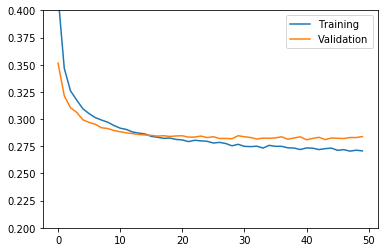

6356/6356 [==============================] - 0s 39us/step
{'loss': 0.2828823055689855, 'f_2': 0.38360274561845764, 'acc': 0.904657016954308}


In [112]:
model_8_3_adamax = model_8_3('model_8_3_adamax', nodes=15, activation='relu', optimizer='adamax')
testmodel(model_8_3_adamax, False, 32, 0.5)

Model X.3 (Adam) {'loss': 0.2840201926538973, 'f_2': 0.3858319894921484, 'acc': 0.9008810572312117}

Compared to the best performance (Adam), the results of Adamax are positive: Testing loss decreases slightly, F-2 score is practically the same, but accuracy increases dramatically. In addition, the training and validation loss show a smoother learning, and they seem to approximate more closely at a value slightly lower than they did for the model using Adam. Therefore, Adamax is better. 

RMSProp, Adam < Adamax

#### Nadam

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3704 - f_2: 0.2121 - acc: 0.8775 - val_loss: 0.3057 - val_f_2: 0.2905 - val_acc: 0.9019

Epoch 00001: val_loss improved from inf to 0.30570, saving model to arch_test_weights/model_8_3_nadam.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3073 - f_2: 0.3176 - acc: 0.9021 - val_loss: 0.2948 - val_f_2: 0.3487 - val_acc: 0.9021

Epoch 00002: val_loss improved from 0.30570 to 0.29484, saving model to arch_test_weights/model_8_3_nadam.best.hdf5
Epoch 3/50
 - 2s - loss: 0.2963 - f_2: 0.3336 - acc: 0.9046 - val_loss: 0.2914 - val_f_2: 0.3126 - val_acc: 0.9036

Epoch 00003: val_loss improved from 0.29484 to 0.29145, saving model to arch_test_weights/model_8_3_nadam.best.hdf5
Epoch 4/50
 - 2s - loss: 0.2916 - f_2: 0.3402 - acc: 0.9037 - val_loss: 0.2884 - val_f_2: 0.3203 - val_acc: 0.9023

Epoch 00004: val_loss improved from 0.29145 to 0.28844, saving model to arch_test_weights/model_8_3_nadam.best.hdf5
Epoch 5/50
 - 2s - loss: 0.

 - 2s - loss: 0.2685 - f_2: 0.3992 - acc: 0.9087 - val_loss: 0.2818 - val_f_2: 0.4135 - val_acc: 0.9066

Epoch 00045: val_loss did not improve from 0.27901
Epoch 46/50
 - 2s - loss: 0.2677 - f_2: 0.3957 - acc: 0.9080 - val_loss: 0.2808 - val_f_2: 0.4262 - val_acc: 0.9007

Epoch 00046: val_loss did not improve from 0.27901
Epoch 47/50
 - 2s - loss: 0.2678 - f_2: 0.4149 - acc: 0.9088 - val_loss: 0.2831 - val_f_2: 0.4200 - val_acc: 0.9007

Epoch 00047: val_loss did not improve from 0.27901
Epoch 48/50
 - 2s - loss: 0.2677 - f_2: 0.4081 - acc: 0.9087 - val_loss: 0.2796 - val_f_2: 0.3515 - val_acc: 0.9042

Epoch 00048: val_loss did not improve from 0.27901
Epoch 49/50
 - 2s - loss: 0.2677 - f_2: 0.4059 - acc: 0.9087 - val_loss: 0.2805 - val_f_2: 0.4085 - val_acc: 0.9032

Epoch 00049: val_loss did not improve from 0.27901
Epoch 50/50
 - 2s - loss: 0.2654 - f_2: 0.4317 - acc: 0.9112 - val_loss: 0.2819 - val_f_2: 0.3405 - val_acc: 0.9005

Epoch 00050: val_loss did not improve from 0.27901


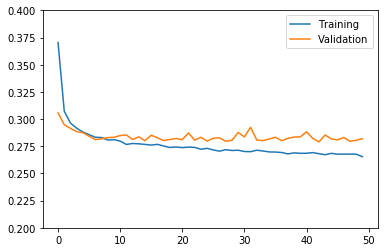

6356/6356 [==============================] - 0s 38us/step
{'loss': 0.28523869888447906, 'f_2': 0.3820608801013907, 'acc': 0.904814348609437}


In [113]:
model_8_3_nadam = model_8_3('model_8_3_nadam', nodes=15, activation='relu', optimizer='nadam')
testmodel(model_8_3_nadam, False, 32, 0.5)

Model X.3 (Adamax) {'loss': 0.2828823055689855, 'f_2': 0.38360274561845764, 'acc': 0.904657016954308}

Compared to the model using Adamax, Nadam is extremely close. The F-2 score is just below Adamax's and the loss is higher, but the accuracy is higher as well. However, due to the very rough learning process and the greater distance between the learning curves, I am inclined to stick with Adamax.

RMSProp, Adam, Nadam < Adamax

#### Adagrad

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3856 - f_2: 0.0107 - acc: 0.8716 - val_loss: 0.3501 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 0.35012, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3524 - f_2: 0.0102 - acc: 0.8726 - val_loss: 0.3385 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00002: val_loss improved from 0.35012 to 0.33851, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3453 - f_2: 0.0142 - acc: 0.8726 - val_loss: 0.3331 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00003: val_loss improved from 0.33851 to 0.33314, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 4/50
 - 1s - loss: 0.3416 - f_2: 0.0126 - acc: 0.8726 - val_loss: 0.3306 - val_f_2: 0.0063 - val_acc: 0.8692

Epoch 00004: val_loss improved from 0.33314 to 0.33060, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 5/50
 - 2s - 

 - 1s - loss: 0.3132 - f_2: 0.3161 - acc: 0.9035 - val_loss: 0.3106 - val_f_2: 0.3244 - val_acc: 0.9027

Epoch 00036: val_loss did not improve from 0.31053
Epoch 37/50
 - 1s - loss: 0.3100 - f_2: 0.3152 - acc: 0.9034 - val_loss: 0.3103 - val_f_2: 0.3188 - val_acc: 0.9021

Epoch 00037: val_loss improved from 0.31053 to 0.31030, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 38/50
 - 1s - loss: 0.3136 - f_2: 0.3145 - acc: 0.9031 - val_loss: 0.3100 - val_f_2: 0.3237 - val_acc: 0.9030

Epoch 00038: val_loss improved from 0.31030 to 0.30998, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 39/50
 - 1s - loss: 0.3131 - f_2: 0.3212 - acc: 0.9023 - val_loss: 0.3097 - val_f_2: 0.3265 - val_acc: 0.9027

Epoch 00039: val_loss improved from 0.30998 to 0.30966, saving model to arch_test_weights/model_8_3_adagrad.best.hdf5
Epoch 40/50
 - 1s - loss: 0.3123 - f_2: 0.3246 - acc: 0.9028 - val_loss: 0.3096 - val_f_2: 0.3246 - val_acc: 0.9029

Epoch 00040: val_loss 

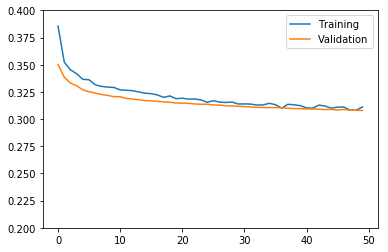

6356/6356 [==============================] - 0s 38us/step
{'loss': 0.3080770391724708, 'f_2': 0.3227281349232784, 'acc': 0.9037130270235338}


In [114]:
model_8_3_adagrad = model_8_3('model_8_3_adagrad', nodes=15, activation='relu', optimizer='adagrad')
testmodel(model_8_3_adagrad, False, 32, 0.5)

Model X.3 (Adamax) {'loss': 0.2828823055689855, 'f_2': 0.38360274561845764, 'acc': 0.904657016954308}

Adagrad's performance is clearly the worst one of the four studied. Its testing loss is the highest, its F-2 score is comparatively very low, and its accuracy is also below that of Adamax. It can be ruled out quickly. 

RMSProp, Adam, Nadam, Adagrad < Adamax

## Model 9

From the last generation, we concluded that Model X.2 works best with RMSprop while Model X.3 works best with Adamax. These are the optimizers that we will be using from here onwards. 

This generation is concerned with the activation functions of the models' layers. ReLU activations are the activation functions of hidden layers par excellence, but they aren't the only ones available. For this generation of models, I will attempt to use a different activation function. From those available in Keras, the most common ones are Sigmoid, Tanh, and ReLu, which we have already used. 

Because the Sigmoid function presents vanishing gradients, it is not useful. In this generation we will attempt to use Tanh instead of ReLU, and experiment with Leaky ReLU as well, to examine how the model would behave with this more advanced activation function.

In [118]:
from keras.layers import LeakyReLU

lrelu = LeakyReLU(alpha=0.3)

### Model 9.2

In [120]:
def model_9_2(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

#### Tanh

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3730 - f_2: 0.2660 - acc: 0.8869 - val_loss: 0.3248 - val_f_2: 0.3002 - val_acc: 0.9001

Epoch 00001: val_loss improved from inf to 0.32479, saving model to arch_test_weights/model_9_2_tanh.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3220 - f_2: 0.3042 - acc: 0.9018 - val_loss: 0.3092 - val_f_2: 0.3158 - val_acc: 0.9009

Epoch 00002: val_loss improved from 0.32479 to 0.30917, saving model to arch_test_weights/model_9_2_tanh.best.hdf5
Epoch 3/50
 - 1s - loss: 0.3095 - f_2: 0.2962 - acc: 0.9012 - val_loss: 0.3017 - val_f_2: 0.3123 - val_acc: 0.9027

Epoch 00003: val_loss improved from 0.30917 to 0.30174, saving model to arch_test_weights/model_9_2_tanh.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3022 - f_2: 0.2917 - acc: 0.9016 - val_loss: 0.2975 - val_f_2: 0.2989 - val_acc: 0.9025

Epoch 00004: val_loss improved from 0.30174 to 0.29754, saving model to arch_test_weights/model_9_2_tanh.best.hdf5
Epoch 5/50
 - 1s - loss: 0.2976

 - 2s - loss: 0.2778 - f_2: 0.3407 - acc: 0.9036 - val_loss: 0.2860 - val_f_2: 0.3793 - val_acc: 0.9027

Epoch 00044: val_loss did not improve from 0.28331
Epoch 45/50
 - 2s - loss: 0.2771 - f_2: 0.3447 - acc: 0.9045 - val_loss: 0.2838 - val_f_2: 0.3640 - val_acc: 0.9023

Epoch 00045: val_loss did not improve from 0.28331
Epoch 46/50
 - 2s - loss: 0.2764 - f_2: 0.3550 - acc: 0.9048 - val_loss: 0.2859 - val_f_2: 0.3174 - val_acc: 0.9027

Epoch 00046: val_loss did not improve from 0.28331
Epoch 47/50
 - 2s - loss: 0.2770 - f_2: 0.3428 - acc: 0.9030 - val_loss: 0.2844 - val_f_2: 0.3401 - val_acc: 0.9023

Epoch 00047: val_loss did not improve from 0.28331
Epoch 48/50
 - 2s - loss: 0.2765 - f_2: 0.3501 - acc: 0.9043 - val_loss: 0.2840 - val_f_2: 0.3330 - val_acc: 0.9023

Epoch 00048: val_loss did not improve from 0.28331
Epoch 49/50
 - 1s - loss: 0.2762 - f_2: 0.3509 - acc: 0.9046 - val_loss: 0.2834 - val_f_2: 0.3454 - val_acc: 0.9029

Epoch 00049: val_loss did not improve from 0.28331
Epoc

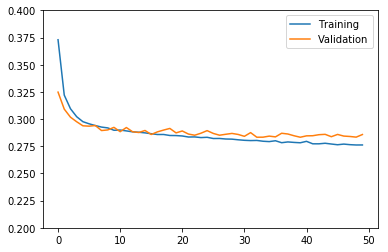

6356/6356 [==============================] - 0s 42us/step
{'loss': 0.28462366154915586, 'f_2': 0.326207065828806, 'acc': 0.9043423536065391}


In [121]:
model_9_2_tanh = model_9_2('model_9_2_tanh', nodes=15, activation='tanh', optimizer='rmsprop')
testmodel(model_9_2_tanh, False, 32, 0.5)

Model X.2 (ReLU): {'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}

When compared to the performance of the model using ReLU, it is evident that ReLU works better than Tanh. The testing loss is lower for the former, the F-2 Score is a lot higher, and the accuracy is nearly on par. Algthough the training process of the Tanh model seems to be better from the graph, in the context of the problem at hand we require an emphasis in good F-2 Scores. Therefore, ReLU primes over Tanh. 

Tanh < ReLU.

#### Leaky ReLU

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3820 - f_2: 0.1379 - acc: 0.8845 - val_loss: 0.3295 - val_f_2: 0.3183 - val_acc: 0.9038

Epoch 00001: val_loss improved from inf to 0.32945, saving model to arch_test_weights/model_8_2_leakyrelu.best.hdf5
Epoch 2/50
 - 1s - loss: 0.3232 - f_2: 0.3067 - acc: 0.9022 - val_loss: 0.3127 - val_f_2: 0.3068 - val_acc: 0.9027

Epoch 00002: val_loss improved from 0.32945 to 0.31274, saving model to arch_test_weights/model_8_2_leakyrelu.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3112 - f_2: 0.3157 - acc: 0.9028 - val_loss: 0.3042 - val_f_2: 0.3142 - val_acc: 0.9017

Epoch 00003: val_loss improved from 0.31274 to 0.30416, saving model to arch_test_weights/model_8_2_leakyrelu.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3043 - f_2: 0.3248 - acc: 0.9031 - val_loss: 0.2993 - val_f_2: 0.3388 - val_acc: 0.9027

Epoch 00004: val_loss improved from 0.30416 to 0.29928, saving model to arch_test_weights/model_8_2_leakyrelu.best.hdf5
Epoch 5/50



Epoch 00044: val_loss did not improve from 0.28477
Epoch 45/50
 - 2s - loss: 0.2755 - f_2: 0.3743 - acc: 0.9046 - val_loss: 0.2862 - val_f_2: 0.3755 - val_acc: 0.9007

Epoch 00045: val_loss did not improve from 0.28477
Epoch 46/50
 - 2s - loss: 0.2751 - f_2: 0.3792 - acc: 0.9051 - val_loss: 0.2864 - val_f_2: 0.3945 - val_acc: 0.9017

Epoch 00046: val_loss did not improve from 0.28477
Epoch 47/50
 - 2s - loss: 0.2742 - f_2: 0.3798 - acc: 0.9054 - val_loss: 0.2851 - val_f_2: 0.3401 - val_acc: 0.9007

Epoch 00047: val_loss did not improve from 0.28477
Epoch 48/50
 - 2s - loss: 0.2744 - f_2: 0.3765 - acc: 0.9063 - val_loss: 0.2923 - val_f_2: 0.3504 - val_acc: 0.9009

Epoch 00048: val_loss did not improve from 0.28477
Epoch 49/50
 - 2s - loss: 0.2748 - f_2: 0.3802 - acc: 0.9048 - val_loss: 0.2865 - val_f_2: 0.3384 - val_acc: 0.9007

Epoch 00049: val_loss did not improve from 0.28477
Epoch 50/50
 - 2s - loss: 0.2756 - f_2: 0.3743 - acc: 0.9051 - val_loss: 0.2872 - val_f_2: 0.3524 - val_acc:

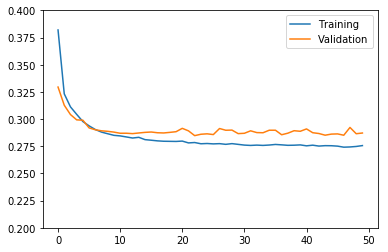

6356/6356 [==============================] - 0s 39us/step
{'loss': 0.28483472480347805, 'f_2': 0.34148257817925165, 'acc': 0.9022970421273728}


In [122]:
model_9_2_leakyrelu = model_9_2('model_8_2_leakyrelu', nodes=15, activation=lrelu, optimizer='rmsprop')
testmodel(model_9_2_leakyrelu, False, 32, 0.5)

Model X.2 (ReLU): {'loss': 0.29084449355672787, 'f_2': 0.3956238929385663, 'acc': 0.9033983636757651}

When compared to the performance of the model using ReLU, its performance using LeakyReLU is not that much better. Although the training process suggests the validation and training losses approximate each other better, the F-2 score and accuracy present a large drop. Therefore, ReLU primes for model X.2.

Tanh, LeakyReLU < ReLU.

### Model 9.3

In [119]:
def model_9_3(name, nodes, activation, optimizer):
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation=activation))
    model.add(Dense(nodes, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation=activation, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 3rd dropout layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f_2, 'accuracy'])
    model.name = name
    return model

#### Tanh

Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3834 - f_2: 0.2690 - acc: 0.8853 - val_loss: 0.3357 - val_f_2: 0.3002 - val_acc: 0.9030

Epoch 00001: val_loss improved from inf to 0.33571, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3355 - f_2: 0.2937 - acc: 0.9018 - val_loss: 0.3202 - val_f_2: 0.3028 - val_acc: 0.9021

Epoch 00002: val_loss improved from 0.33571 to 0.32017, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3220 - f_2: 0.3104 - acc: 0.9016 - val_loss: 0.3131 - val_f_2: 0.3190 - val_acc: 0.9025

Epoch 00003: val_loss improved from 0.32017 to 0.31310, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3159 - f_2: 0.3040 - acc: 0.9018 - val_loss: 0.3050 - val_f_2: 0.3104 - val_acc: 0.9030

Epoch 00004: val_loss improved from 0.31310 to 0.30502, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 5/50
 - 2s - loss: 0.3095

 - 2s - loss: 0.2813 - f_2: 0.3310 - acc: 0.9036 - val_loss: 0.2814 - val_f_2: 0.3117 - val_acc: 0.9017

Epoch 00040: val_loss improved from 0.28205 to 0.28141, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 41/50
 - 2s - loss: 0.2812 - f_2: 0.3324 - acc: 0.9038 - val_loss: 0.2814 - val_f_2: 0.3319 - val_acc: 0.9030

Epoch 00041: val_loss improved from 0.28141 to 0.28140, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 42/50
 - 2s - loss: 0.2806 - f_2: 0.3458 - acc: 0.9058 - val_loss: 0.2809 - val_f_2: 0.3361 - val_acc: 0.9027

Epoch 00042: val_loss improved from 0.28140 to 0.28091, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 43/50
 - 2s - loss: 0.2801 - f_2: 0.3256 - acc: 0.9029 - val_loss: 0.2795 - val_f_2: 0.3430 - val_acc: 0.9036

Epoch 00043: val_loss improved from 0.28091 to 0.27946, saving model to arch_test_weights/model_9_3_tanh.best.hdf5
Epoch 44/50
 - 2s - loss: 0.2797 - f_2: 0.3279 - acc: 0.9036 - val_loss: 0.2850 - va

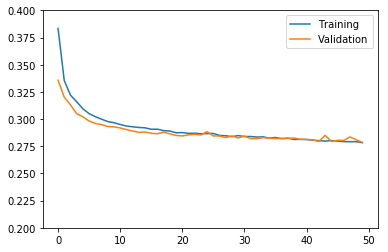

6356/6356 [==============================] - 0s 42us/step
{'loss': 0.28391524114047606, 'f_2': 0.3299530741966308, 'acc': 0.9030837004030179}


In [123]:
model_9_3_tanh = model_9_3('model_9_3_tanh', nodes=15, activation='tanh', optimizer='adamax')
testmodel(model_9_3_tanh, False, 32, 0.5)

Model X.3 (ReLU) {'loss': 0.2828823055689855, 'f_2': 0.38360274561845764, 'acc': 0.904657016954308}

Compared to the model using ReLU, the scores for Tanh are not that great. The testing loss is practically the same, the F-2 score decreases dramatically, and the accuracy drops somewhat. On the other hand, Tanh seems to make the training and validation losses converge very nicely during training. However, for the purposes of our model, the F-2 Score and the accuracy are better indicators. 

Tanh < ReLU

#### Leaky ReLU

/Users/MHurtado/anaconda3/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 20336 samples, validate on 5085 samples
Epoch 1/50
 - 4s - loss: 0.3967 - f_2: 0.1627 - acc: 0.8850 - val_loss: 0.3346 - val_f_2: 0.2966 - val_acc: 0.9001

Epoch 00001: val_loss improved from inf to 0.33463, saving model to arch_test_weights/model_9_3_leakyrelu.best.hdf5
Epoch 2/50
 - 2s - loss: 0.3351 - f_2: 0.2977 - acc: 0.9020 - val_loss: 0.3180 - val_f_2: 0.3080 - val_acc: 0.9021

Epoch 00002: val_loss improved from 0.33463 to 0.31802, saving model to arch_test_weights/model_9_3_leakyrelu.best.hdf5
Epoch 3/50
 - 2s - loss: 0.3186 - f_2: 0.3058 - acc: 0.9017 - val_loss: 0.3090 - val_f_2: 0.3210 - val_acc: 0.8999

Epoch 00003: val_loss improved from 0.31802 to 0.30901, saving model to arch_test_weights/model_9_3_leakyrelu.best.hdf5
Epoch 4/50
 - 2s - loss: 0.3123 - f_2: 0.3136 - acc: 0.9026 - val_loss: 0.3024 - val_f_2: 0.3356 - val_acc: 0.9011

Epoch 00004: val_loss improved from 0.30901 to 0.30236, saving model to arch_test_weights/model_9_3_leakyrelu.best.hdf5
Epoch 5/50


 - 2s - loss: 0.2740 - f_2: 0.3382 - acc: 0.9044 - val_loss: 0.2826 - val_f_2: 0.3434 - val_acc: 0.9015

Epoch 00042: val_loss did not improve from 0.28167
Epoch 43/50
 - 2s - loss: 0.2748 - f_2: 0.3548 - acc: 0.9046 - val_loss: 0.2834 - val_f_2: 0.3719 - val_acc: 0.9009

Epoch 00043: val_loss did not improve from 0.28167
Epoch 44/50
 - 2s - loss: 0.2731 - f_2: 0.3712 - acc: 0.9049 - val_loss: 0.2841 - val_f_2: 0.3629 - val_acc: 0.9030

Epoch 00044: val_loss did not improve from 0.28167
Epoch 45/50
 - 2s - loss: 0.2731 - f_2: 0.3626 - acc: 0.9038 - val_loss: 0.2837 - val_f_2: 0.3291 - val_acc: 0.9038

Epoch 00045: val_loss did not improve from 0.28167
Epoch 46/50
 - 2s - loss: 0.2745 - f_2: 0.3649 - acc: 0.9039 - val_loss: 0.2831 - val_f_2: 0.3558 - val_acc: 0.9027

Epoch 00046: val_loss did not improve from 0.28167
Epoch 47/50
 - 2s - loss: 0.2750 - f_2: 0.3567 - acc: 0.9049 - val_loss: 0.2819 - val_f_2: 0.3425 - val_acc: 0.9027

Epoch 00047: val_loss did not improve from 0.28167
Epoc

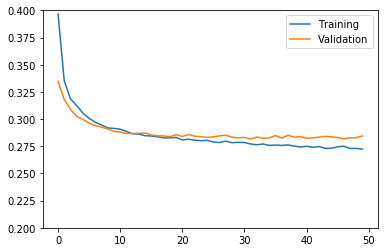

6356/6356 [==============================] - 0s 43us/step
{'loss': 0.283728102586643, 'f_2': 0.3306198269529855, 'acc': 0.902769037055249}


In [124]:
model_9_3_leakyrelu = model_9_3('model_9_3_leakyrelu', nodes=15, activation=lrelu, optimizer='adamax')
testmodel(model_9_3_leakyrelu, False, 32, 0.5)

Model X.3 (ReLU) {'loss': 0.2828823055689855, 'f_2': 0.38360274561845764, 'acc': 0.904657016954308}

Lastly, although the training and validation losses of Leaky ReLU show a pretty nice approximation, the performance scores obtained from that model again show a decrease in model performance in comparison to the model using ReLU. Therefore, ReLU prime for this model. 

LeakyReLU, Tanh < ReLU. 

## Conclusion

The resulting 'best' architectures for both models are as follows:

In [125]:
def model_10_2():
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu'))
    model.add(Dense(nodes, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f_2, 'accuracy'])
    return model

In [126]:
def model_10_3():
    model = Sequential()
    model.add(Dense(units=X_train_red.shape[1], input_dim=X_train_red.shape[1], activation='relu'))
    model.add(Dense(nodes, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 1st dropout layer
    model.add(Dense(nodes + 5, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 2nd dropout layer
    model.add(Dense(nodes + 10, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2)) # 3rd dropout layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[f_2, 'accuracy'])
    return model

It is important to note that the fine-tuning of parameters is still necessary, and will be carried out using Grid Search Cross-Validation. The above experimentation was just an attempt at correcting model behavior during training using a more analytical and manual approach. 

Of course, by no means do these final two models represent the best possible models that could be used to tackle the problem. However, the above process is a good way to narrow down in a considerable way the infinite possibilities that could have been used to tackle the problem. Because the models are the product of careful reasoning and observation, they should improve the overall outcome of the project. 